In [1]:
#importing necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import glob
import math
import pickle
import statistics
from sklearn import metrics
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

## Goal

In this notebook, we perform time series analysis and SARIMA modeling to predict 5 best real estate investments (by zipcode) in NYC. Our investor in mind is risk averse, looking to minimize error and variability within our predictions.

<a id='toc'></a>

## Table of Contents

### [Load in Data](#prep)

### [Explanatory Data Analysis](#eda)

### [Data Extraction](#de)

### [Computing Rolling Statistics](#crs)

### [Computing Rolling Event Stats](#cres)

### [Creating Train and Test Datasets](#cttd)

### [Hypertuning Parameters and Model Fitting](#hpmf)

### [Results](#r)

### [Future Work](#fw)

<a id='prep'></a>

[Back to Top of Notebook](#toc)
## Load in Data

In [2]:
#finds all the pathnames with .csv format
all_files = glob.glob('*.csv')
#removing MTeamSpellings.csv file from list
all_files.remove('MTeamSpellings.csv')
all_files

['MNCAATourneyDetailedResults.csv',
 'MNCAATourneyCompactResults.csv',
 'MSeasons.csv',
 'MEvents2018.csv',
 'MEvents2019.csv',
 'MPlayers.csv',
 'MRegularSeasonDetailedResults.csv',
 'MNCAATourneySlots.csv',
 'MGameCities.csv',
 'MSampleSubmissionStage1_2020.csv',
 'MConferenceTourneyGames.csv',
 'Cities.csv',
 'MRegularSeasonCompactResults.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MTeamConferences.csv',
 'MTeamCoaches.csv',
 'MEvents2017.csv',
 'MMasseyOrdinals.csv',
 'MEvents2016.csv',
 'Conferences.csv',
 'MTeams.csv',
 'MNCAATourneySeeds.csv',
 'MEvents2015.csv',
 'MSecondaryTourneyTeams.csv',
 'MSecondaryTourneyCompactResults.csv']

In [3]:
#create empty dictionary
dic = {}
#for loop through all_files list counting the iteration using enumerate
for idx, i in enumerate(all_files):
    #reading in new dataframe naming each as df + the iteration number assigned
    exec(f'df{idx} = pd.read_csv(i)')
    #assign name of csv file to the df file it refers to
    dic['df' + str(idx)] = i

In [4]:
#for loop printing first 5 rows of each dataframe
for x in dic:
    #print csv file name
    print(dic[x])
    #display first 5 rows of dataframe
    exec(f'display({x}.head())')
    print()
    print()
    print()
    print()
#print dictionary for further use
dic

MNCAATourneyDetailedResults.csv


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19






MNCAATourneyCompactResults.csv


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0






MSeasons.csv


,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast






MEvents2018.csv


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,7850408,2018,11,1104,1272,82,70,0,0,15,1104,130,made3,unk,0,0,0
1,7850409,2018,11,1104,1272,82,70,0,0,15,1104,129,assist,NaN,0,0,0
2,7850410,2018,11,1104,1272,82,70,0,0,39,1272,6242,turnover,unk,0,0,0
3,7850411,2018,11,1104,1272,82,70,0,0,43,1104,143,miss2,jump,0,0,0
4,7850412,2018,11,1104,1272,82,70,0,0,43,1104,129,reb,off,0,0,0






MEvents2019.csv


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,10442717,2019,1,1104,1380,82,62,0,0,18,1380,10314,made2,jump,0,0,0
1,10442718,2019,1,1104,1380,82,62,0,0,18,1380,10307,assist,NaN,0,0,0
2,10442719,2019,1,1104,1380,82,62,0,0,42,1104,129,made2,jump,0,0,0
3,10442720,2019,1,1104,1380,82,62,0,0,58,1380,10303,turnover,unk,0,0,0
4,10442721,2019,1,1104,1380,82,62,0,0,63,1104,143,made3,unk,0,0,0






MPlayers.csv


,PlayerID,LastName,FirstName,TeamID
0,1,Albright,Christian,1101
1,2,Cameron,Tobias,1101
2,3,Cobb,Chase,1101
3,4,Cooke,Austin,1101
4,5,Crnic,Jovan,1101






MRegularSeasonDetailedResults.csv


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14






MNCAATourneySlots.csv


,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12






MGameCities.csv


,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2010,7,1143,1293,Regular,4027
1,2010,7,1314,1198,Regular,4061
2,2010,7,1326,1108,Regular,4080
3,2010,7,1393,1107,Regular,4340
4,2010,9,1143,1178,Regular,4027






MSampleSubmissionStage1_2020.csv


,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5






MConferenceTourneyGames.csv


,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
0,2001,a_sun,121,1194,1144
1,2001,a_sun,121,1416,1240
2,2001,a_sun,122,1209,1194
3,2001,a_sun,122,1359,1239
4,2001,a_sun,122,1391,1273






Cities.csv


,CityID,City,State
0,4001,Abilene,TX
1,4002,Akron,OH
2,4003,Albany,NY
3,4004,Albuquerque,NM
4,4005,Allentown,PA






MRegularSeasonCompactResults.csv


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0






MNCAATourneySeedRoundSlots.csv


,Seed,GameRound,GameSlot,EarlyDayNum,LateDayNum
0,W01,1,R1W1,136,137
1,W01,2,R2W1,138,139
2,W01,3,R3W1,143,144
3,W01,4,R4W1,145,146
4,W01,5,R5WX,152,152






MTeamConferences.csv


,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac






MTeamCoaches.csv


,Season,TeamID,FirstDayNum,LastDayNum,CoachName
0,1985,1102,0,154,reggie_minton
1,1985,1103,0,154,bob_huggins
2,1985,1104,0,154,wimp_sanderson
3,1985,1106,0,154,james_oliver
4,1985,1108,0,154,davey_whitney






MEvents2017.csv


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,5216688,2017,11,1104,1157,70,53,0,0,0,1104,6977,sub,in,0,0,0
1,5216689,2017,11,1104,1157,70,53,0,0,15,1157,1899,foul,unk,0,0,0
2,5216690,2017,11,1104,1157,70,53,0,0,15,1157,1899,turnover,unk,0,0,0
3,5216691,2017,11,1104,1157,70,53,0,0,26,1104,140,made3,unk,0,0,0
4,5216692,2017,11,1104,1157,70,53,0,0,26,1104,151,assist,NaN,0,0,0






MMasseyOrdinals.csv


,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260






MEvents2016.csv


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,2560826,2016,11,1104,1244,77,64,0,0,13,1104,151,miss2,lay,0,0,0
1,2560827,2016,11,1104,1244,77,64,0,0,13,1104,151,reb,off,0,0,0
2,2560828,2016,11,1104,1244,77,64,0,0,16,1244,5199,foul,unk,0,0,0
3,2560829,2016,11,1104,1244,77,64,0,0,16,1104,151,miss1,unk,0,0,0
4,2560830,2016,11,1104,1244,77,64,0,0,16,1104,0,reb,deadb,0,0,0






Conferences.csv


,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference






MTeams.csv


,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2020
1,1102,Air Force,1985,2020
2,1103,Akron,1985,2020
3,1104,Alabama,1985,2020
4,1105,Alabama A&M,2000,2020






MNCAATourneySeeds.csv


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374






MEvents2015.csv


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,1,2015,11,1103,1420,74,57,0,0,19,1103,100,miss3,unk,0,0,0
1,2,2015,11,1103,1420,74,57,0,0,19,1420,11784,reb,def,0,0,0
2,3,2015,11,1103,1420,74,57,0,0,27,1420,11789,made2,dunk,0,0,0
3,4,2015,11,1103,1420,74,57,0,0,27,1420,11803,assist,NaN,0,0,0
4,5,2015,11,1103,1420,74,57,0,0,59,1103,87,made2,jump,0,0,0






MSecondaryTourneyTeams.csv


,Season,SecondaryTourney,TeamID
0,1985,NIT,1108
1,1985,NIT,1133
2,1985,NIT,1139
3,1985,NIT,1145
4,1985,NIT,1151






MSecondaryTourneyCompactResults.csv


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,SecondaryTourney
0,1985,136,1151,67,1155,65,H,0,NIT
1,1985,136,1153,77,1245,61,H,0,NIT
2,1985,136,1201,79,1365,76,H,0,NIT
3,1985,136,1231,79,1139,57,H,0,NIT
4,1985,136,1249,78,1222,71,H,0,NIT


{'df0': 'MNCAATourneyDetailedResults.csv',
 'df1': 'MNCAATourneyCompactResults.csv',
 'df2': 'MSeasons.csv',
 'df3': 'MEvents2018.csv',
 'df4': 'MEvents2019.csv',
 'df5': 'MPlayers.csv',
 'df6': 'MRegularSeasonDetailedResults.csv',
 'df7': 'MNCAATourneySlots.csv',
 'df8': 'MGameCities.csv',
 'df9': 'MSampleSubmissionStage1_2020.csv',
 'df10': 'MConferenceTourneyGames.csv',
 'df11': 'Cities.csv',
 'df12': 'MRegularSeasonCompactResults.csv',
 'df13': 'MNCAATourneySeedRoundSlots.csv',
 'df14': 'MTeamConferences.csv',
 'df15': 'MTeamCoaches.csv',
 'df16': 'MEvents2017.csv',
 'df17': 'MMasseyOrdinals.csv',
 'df18': 'MEvents2016.csv',
 'df19': 'Conferences.csv',
 'df20': 'MTeams.csv',
 'df21': 'MNCAATourneySeeds.csv',
 'df22': 'MEvents2015.csv',
 'df23': 'MSecondaryTourneyTeams.csv',
 'df24': 'MSecondaryTourneyCompactResults.csv'}

<a id='eda'></a>

We now have 24 dataframes for each of our csv files. It is important for our later functions and cell blocks that our data is read in with the correct dataframe name assignment. Below you can see how they should be labeled:

df0: 'MNCAATourneyDetailedResults.csv'  
df1: 'MNCAATourneyCompactResults.csv'  
df2: 'MSeasons.csv'  
df3: 'MEvents2018.csv'  
df4: 'MEvents2019.csv'  
df5: 'MPlayers.csv'  
df6: 'MRegularSeasonDetailedResults.csv'  
df7: 'MNCAATourneySlots.csv'  
df8: 'MGameCities.csv'  
df9: 'MSampleSubmissionStage1_2020.csv'  
df10: 'MConferenceTourneyGames.csv'  
df11: 'Cities.csv'  
df12: 'MRegularSeasonCompactResults.csv'  
df13: 'MNCAATourneySeedRoundSlots.csv'  
df14: 'MTeamConferences.csv'  
df15: 'MTeamCoaches.csv'  
df16: 'MEvents2017.csv'  
df17: 'MMasseyOrdinals.csv'  
df18: 'MEvents2016.csv'  
df19: 'Conferences.csv'  
df20: 'MTeams.csv'  
df21: 'MNCAATourneySeeds.csv'  
df22: 'MEvents2015.csv'  
df23: 'MSecondaryTourneyTeams.csv'  
df24: 'MSecondaryTourneyCompactResults.csv'

[Back to Top of Notebook](#toc)
## Explanatory Data Analysis

Our primary goal is to create a model to predict first round matchups for 2020 season. Our train data will be regular season results from 2017-2019 and our test data will be first round matchups for those years. We will only consider years 2017-2019, because NCAA eligibility allows players to play a maximum of 4 years for NCAA programs. Therefore, the maximum years a player may be a part of a given program is 4 years.

In basketball, it is easy to say a way better team will obviously beat a worse team, say number 1 seed vs number 16, but as you get closer in talent, it becomes increasingly more difficult. Then, there are of course the wildcard games, known as the upsets, when a lower seed team beats out a higher seed team, maybe due to injuries, better preperation, or maybe it was just a team's night to play well.

Regardless, let us begin by looking at some past trends in the tournament to get a better understanding of first round matchups, specifically upsets.

In [5]:
#creating new dataframe restricting DayNum in Tournament results dataframe to first round matchups
dfupset = df0[df0.DayNum >= 136]
dfupset = dfupset[dfupset.DayNum <= 137]
#reset index
dfupset.reset_index(drop=True, inplace=True)
#for loop iterating through Winning Team ID column
#resulting in a new binary categorical column in dfuupset dataframe
#with output 1 if winning team was lower seeded team
for idx, x in enumerate(dfupset.WTeamID):
    #creating two new dataframes of Seed dataframe restricting for winning team and losing team IDs
    #where season is same as the corresponding game in dfupset dataframe
    teamw = df21[df21.TeamID == x]
    teamw = teamw[teamw.Season == dfupset.Season[idx]]
    teaml = df21[df21.TeamID == dfupset.LTeamID.iloc[idx]]
    teaml = teaml[teaml.Season == dfupset.Season[idx]]
    #place seed value in new columns in dfupset dataframe
    dfupset.loc[idx, 'WSeed'] = int(teamw.Seed.iloc[0][1:3])
    dfupset.loc[idx, 'LSeed'] = int(teaml.Seed.iloc[0][1:3])
    dfupset.loc[idx, 'Seeddiff'] = dfupset.WSeed.iloc[idx] - dfupset.LSeed.iloc[idx]
    #place whether game result was an upset in new column in dfupset dataframe
    if dfupset.Seeddiff.iloc[idx] < 0:
        dfupset.loc[idx, 'Upset'] = 0
    elif dfupset.Seeddiff.iloc[idx] > 0:
        dfupset.loc[idx, 'Upset'] = 1

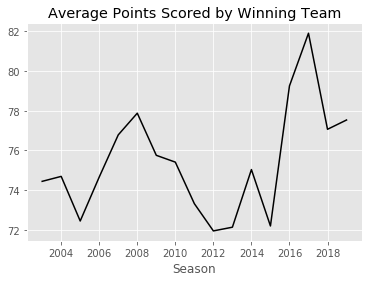

In [6]:
#grouping average winning score by season and plotting line graph 
dfupset.groupby(['Season'])['WScore'].mean().plot(kind='line', color = 'black', title = 'Average Points Scored by Winning Team');

Since the emergence of impportance of analytics in basketball, teams began to value the three point shot more than any other, since 3 points beats out 2. Teams also found themselves taken earlier shots in the shot clock to create more possessions per game as well as running at a faster pace. This resulted in a huge increase in average points scored by teams and a shift in the way the game is played today.

You can see the shift occuring around 2014, where there was a sharp increase in average points scored by the winning teams. The specific timing of the increase could be due to influence from professional basketball as the prolific shooting and success of the Golden State Warriors pushed teams to follow their structure of basketball. More youth and college playaers began to work on skillsets that would make them valuable for professional basketball, and also just a result of copycat as well.

In [7]:
#grouping average winning score by season
wscoretable = dfupset.groupby(['Season'])['WScore'].agg({x:['mean']}).reset_index()
#renaming columns in groupby dataframe
wscoretable.columns = ['Season', 'Mean Score by Winner']
wscoretable

,Season,Mean Score by Winner
0,2003,74.43750
1,2004,74.68750
2,2005,72.43750
3,2006,74.65625
4,2007,76.78125
5,2008,77.87500
6,2009,75.75000
7,2010,75.40625
8,2011,73.31250
9,2012,71.93750


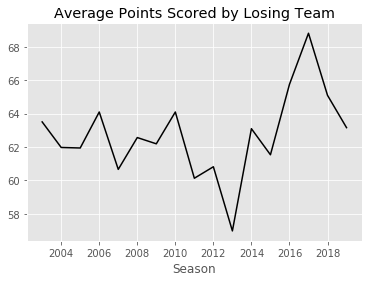

In [8]:
#grouping average losing score by season and plotting line graph
dfupset.groupby(['Season'])['LScore'].mean().plot(kind='line', color = 'black', title = 'Average Points Scored by Losing Team');

Similar to the average points scored by the winning teams over time, after 2014, there is a steep incline in points scored by the losing team.

However, if we were to compare the average points scored by the losing team to the winning teams, you may notice that the highest average points scored by our loseres does not even reach the minimum average points scored by the winners. This demonstrates that most of our first round matchups are dominated by the winning team as there is always a consistent difference of 10 or more points per season.

In [9]:
#grouping average losing score by season
lscoretable = dfupset.groupby(['Season'])['LScore'].agg({x:['mean']}).reset_index()
#renaming columns in groupby dataframe
lscoretable.columns = ['Season', 'Mean Score by Loser']
lscoretable

,Season,Mean Score by Loser
0,2003,63.50000
1,2004,61.96875
2,2005,61.93750
3,2006,64.09375
4,2007,60.65625
5,2008,62.56250
6,2009,62.18750
7,2010,64.09375
8,2011,60.12500
9,2012,60.81250


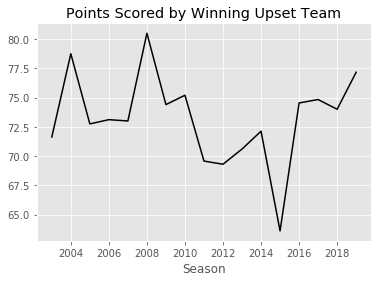

In [10]:
#grouping average winning score by season for rows where upset column equals 1
#and plotting line graph
dfupset[dfupset.Upset == 1].groupby(['Season'])['WScore'].mean().plot(kind='line', color = 'black', title='Points Scored by Winning Upset Team');

When we look at the average points scored by the winner when the winner was a lower seeded team, the average points scored lies between the two lines above. It can be inferred that the games in which an upset occured, the games had lower scoring, possibly due to more defense, poorer shooting or a combination of both.

All three graphs experienced a decrease in scoring in 2015. The 2014-15 NCAA season was dominated by very talented big men, i.e. Karl Anthony-Towns and Jahlil Okafor, and teams were scoring more inside and more physically. This could result in lower average points scored in games throughout the tournament.

In [11]:
#grouping average winning score by season for rows where upset equals 1
seasonupsetstable = dfupset[dfupset.Upset == 1].groupby(['Season'])['WScore'].agg({x:['mean']}).reset_index()
#renaming columns in groupby dataframe
seasonupsetstable.columns = ['Season', 'Mean Score by Upset Winner']
seasonupsetstable

,Season,Mean Score by Upset Winner
0,2003,71.625000
1,2004,78.750000
2,2005,72.750000
3,2006,73.111111
4,2007,73.000000
5,2008,80.500000
6,2009,74.400000
7,2010,75.200000
8,2011,69.571429
9,2012,69.300000


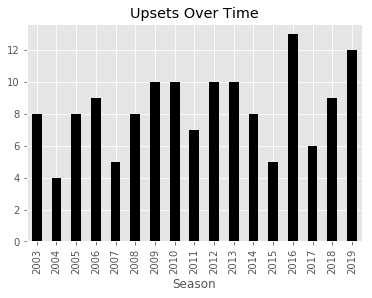

In [12]:
#grouping upsets sum by season and plotting line graph 
dfupset.groupby(['Season'])['Upset'].sum().plot(kind='bar', color = 'black', title='Upsets Over Time');

Since 2003, there has always been 4 or more upsets per year. 2016 had the largest number of upsets, at 13, and 2004 had the lowest at 4. Thre three seasons we are looking to predict, 2017-2019, had an increasing number of upsets with 2019 having the most at 12.

2019 was full of upsets but not that many were suprises if you were to look at the teams closely. Many of the lower seeded teams that won were coming off a hot streak, one of them on a 17-game win streak heading into the tournament. Others had top-talented players who chose to go to smaller schools and showed up big time in the tournament. On the flip-side, some of the higher seeded teams had a lack of completeness to their game and roster, showing holes that could have been taken advantadge of.

In [13]:
#grouping sum of upsets by season
seasonupsetstable = dfupset.groupby(['Season'])['Upset'].agg({x:['sum']}).reset_index()
#renaming columns in groupby dataframe
seasonupsetstable.columns = ['Season', 'Number of Upsets']
seasonupsetstable

,Season,Number of Upsets
0,2003,8.0
1,2004,4.0
2,2005,8.0
3,2006,9.0
4,2007,5.0
5,2008,8.0
6,2009,10.0
7,2010,10.0
8,2011,7.0
9,2012,10.0


In [14]:
#grouping sum of upsets by losing seed
upsetstable = dfupset.groupby(['LSeed'])['Upset'].agg({x:['sum']}).reset_index()
#renaming columns in groupby dataframe
upsetstable.columns = ['Losing Seeds', 'Number of Upsets']
upsetstable

,Losing Seeds,Number of Upsets
0,1.0,1.0
1,2.0,4.0
2,3.0,8.0
3,4.0,14.0
4,5.0,27.0
5,6.0,29.0
6,7.0,26.0
7,8.0,33.0
8,9.0,0.0
9,10.0,0.0


This here is to show you a glimpse of how many upsets have occured by seed since 2003. Only 1 number one seed has lost, ever in this tournament and that came only 4 years ago. As the teams get closer in ranking, the number of upsets increase, as they should.

Let us begin our thought process in our dataset structure.

<a id='de'></a>

[Back to Top of Notebook](#toc)
## Data Extraction

When attempting to predict game results, it is always easier as you get fed in some data about the circumstances of the game specifically; however, we must predict these matchups before we know anything about the game using past data on the two teams. For predicting our results, we will take averages of various statistics for both teams up to the date of that game.

To make processing time for computing these statistics, fitting our model and predicting, we will only use regular season results as our train data for each season.

Our train dataset will rows of games with a winning team and losing team and their various historical statistics. The features will include average differences in per game statistics for both teams. The reason I want to use difference in per game statistics is to not only describe the performance of each team but also show how their performance was relative to their opponent. Our features for each game will include various averages of advanced statistics:

true shooting percentage - team's overall efficiency at shooting the ball,  
pace - number of possessions in a game,  
offensive rating - offensive productive efficiency,  
defensive rating - defensive productive efficiency,  
net rating - overall productive efficiency,  
pythagorean wins - number of wins a team should have based on points scored and points allowed.

They will also include field goal percentages from the first 5 minutes and last 5 minutes of each half. This decision was because I wanted to seperate shooting efficiency by important moments in a game. Splitting the game up into pieces, especially when choosing the best moments to shoot well can strongly influence a win.

Lastly, our features also include various statistics about the day of the specific games, like coach tenure, which refers to the length of time the coach has been with the program. Having a tenured coach gives a program a more experienced leader and a better chance of making it through the grinds of a long season and tournament. You also see better players going to better programs, which is usually a result of the people around the program. Therefore, we have a difference in coach tenure feature, difference in length of time the program has been in Division I basketball (Existence difference), and a difference in ordinal ranking number (the rank in Division I teams given by various rating systems).

Below are functions and cell blocks in which I go through the raw data to extract the averages I need for the train and test datasets.

As I said before, college players are allowed to play for any NCAA program for up to 4 years, therefore, we will also have averages of team statistics from the previous 3 years as well for each of rows. Therefore, we will begin by creating a dataframe for our train data from 2014.

In [249]:
#creating new dataframe from regular season detailed results dataframe
#restricting for seasons with minimum value equal to 2014
df = df6[df6.Season >= 2014]
#reset index
df.reset_index(drop = True, inplace = True)
#print first 5 rows
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2014,4,1102,79,1119,68,N,0,26,49,...,44,10,13,14,20,16,13,4,5,24
1,2014,4,1103,72,1157,63,H,0,25,59,...,14,11,18,15,22,6,20,8,4,22
2,2014,4,1107,74,1373,62,A,0,21,52,...,24,12,23,20,24,12,16,2,6,26
3,2014,4,1112,73,1142,62,H,0,24,42,...,26,11,13,10,16,13,11,4,0,26
4,2014,4,1113,96,1420,61,H,0,27,57,...,23,11,25,11,24,12,16,8,1,30


Here we are calculating the difference in length of time a program has existed in Division I basketball and storing it in our teams dataframe.

In [34]:
#for loop iterating through team ID in team dataframe
#resulting in new season columns with values equal to
#number of years the team has been in Division 1 basketball up to that point
for idx, x in enumerate(df20.TeamID):
    for i in ['2014', '2015', '2016', '2017', '2018', '2019']:
        #if statment testing for if season falls between the existence of the team
        if df20.FirstD1Season[idx] <= int(i) <= df20.LastD1Season[idx]:
            #place new value in new column
            df20.loc[idx, i] = int(i) - df20.FirstD1Season[idx]
        else:
            #place value in new column
            df20.loc[idx, i] = 0
#print first 5 rows of dataframe
df20.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,2014,2015,2016,2017,2018,2019
0,1101,Abilene Chr,2014,2020,0.0,1.0,2.0,3.0,4.0,5.0
1,1102,Air Force,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0
2,1103,Akron,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0
3,1104,Alabama,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0
4,1105,Alabama A&M,2000,2020,14.0,15.0,16.0,17.0,18.0,19.0


We are calculating the coach tenure of each coach for a team by first taking the total number of days they coached for each seaseon, then adding those days for successive years at a program. We then keep those values in the coach dataframe for now.

In [48]:
#for loop iterating through Last Day number in coach dataframe
for idx, x in enumerate(df15.LastDayNum):
    #place difference between Last Day and First Day of coaches' tenure
    #in new 'Days' column
    df15.loc[idx, 'Days'] = df15.LastDayNum.iloc[idx] - df15.FirstDayNum.iloc[idx]
#display first 5 rows of coach dataframe
df15.head()

,Season,TeamID,FirstDayNum,LastDayNum,CoachName,Days
0,1985,1102,0,154,reggie_minton,154.0
1,1985,1103,0,154,bob_huggins,154.0
2,1985,1104,0,154,wimp_sanderson,154.0
3,1985,1106,0,154,james_oliver,154.0
4,1985,1108,0,154,davey_whitney,154.0


In [49]:
#for loop iterating through a list of unique coaches in coach dataframe
for i in list(df15.CoachName.unique()):
    #create proxy dataframe of unique coach
    proxycoach = df15[df15.CoachName == i]
    proxycoach.reset_index(inplace = True)
    #save original indices for later
    proxycoach.rename(columns = {'index': 'bar'}, inplace = True)

    #for loop iterating through season column of proxy dataframe
    for idx, x in enumerate(proxycoach.Season):
        #if first row, place value of Days in the Tenure column
        if idx == 0:
            proxycoach.loc[idx, 'Tenure'] = proxycoach.Days.iloc[idx]
        #checking if the season in previous row is this year minus 1, hence subsequent years
        elif proxycoach.loc[idx - 1, 'Season'] == proxycoach.loc[idx, 'Season'] - 1:
            #checking if the team id of previous season's row is the same as this season's row
            if proxycoach.loc[idx - 1, 'TeamID'] == proxycoach.loc[idx, 'TeamID']:
                #place value of last season's Tenure plus this season's Days in the Tenure column
                proxycoach.loc[idx, 'Tenure'] = proxycoach.Tenure.iloc[idx - 1] + proxycoach.Days.iloc[idx]
            elif proxycoach.loc[idx - 1, 'TeamID'] != proxycoach.loc[idx, 'TeamID']:
                #place value of Days in the Tenure column
                proxycoach.loc[idx, 'Tenure'] = proxycoach.Days.iloc[idx]
        #if season value in previous row is not the immediate previous year to season value in current row
        elif proxycoach.loc[idx - 1, 'Season'] != proxycoach.loc[idx, 'Season'] - 1:
            #place value of Days in the Tenure column
            proxycoach.loc[idx, 'Tenure'] = proxycoach.Days.iloc[idx]
    
    #for loop iterating through bar column, referring to original indices
    for idx, x in enumerate(proxycoach.bar):
        #place Tenure value in approriate row for original coach dataframe
        df15.loc[x, 'CoachTenure'] = proxycoach.Tenure.iloc[idx]

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [50]:
#display first 5 rows of coach dataframe
df15.head()

,Season,TeamID,FirstDayNum,LastDayNum,CoachName,Days,CoachTenure
0,1985,1102,0,154,reggie_minton,154.0,154.0
1,1985,1103,0,154,bob_huggins,154.0,154.0
2,1985,1104,0,154,wimp_sanderson,154.0,154.0
3,1985,1106,0,154,james_oliver,154.0,154.0
4,1985,1108,0,154,davey_whitney,154.0,154.0


Let us look at the average win percentage by coach tenure to see if there is any observable connection between the two.

In [81]:
#create a new dataframe of coach dataframe where season value is at least 2014
coachtenuredf = df15[df15.Season >= 2014]
#reset index
coachtenuredf.reset_index(drop = True, inplace = True)
#create empty list
droplist = []
#for loop iterating through Team ID in coachtenuredf dataframe
for idx, x in enumerate(coachtenuredf.TeamID):
    #we append indices in droplist of rows where coaches did not coach throughout the whole year
    if coachtenuredf.LastDayNum.iloc[idx] != 154:
        droplist.append(idx)
    elif coachtenuredf.FirstDayNum.iloc[idx] != 0:
        droplist.append(idx)
    else:
        #find index of team in teams dataframe using team ID from coachtenuredf
        teamidx = df20[df20['TeamID'] == x].index.tolist()[0]
        #compute value of win percentage from teams dataframe and place value in coachtenuredf
        coachtenuredf.loc[idx, 'Wins'] = (df20['Wins' + str(coachtenuredf.Season.iloc[idx])].iloc[teamidx] / df20['TotalG' + str(coachtenuredf.Season.iloc[idx])].iloc[teamidx])

#drop all rows in drop list corresponding to coaches who did not coach full seasons
coachtenuredf.drop(droplist, axis = 0, inplace = True)
#reset index
coachtenuredf.reset_index(drop = True, inplace = True)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

In [125]:
#grouping average wins by coach tenure score
tenuretable = coachtenuredf.groupby(['CoachTenure'])['Wins'].agg({x:['mean']}).reset_index()
#renaming columns in groupby dataframe
tenuretable.columns = ['CoachTenure', 'Wins']
#displaying first 5 rows of dataframe
tenuretable.head()

//anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,CoachTenure,Wins
0,154.0,0.417447
1,182.0,0.137931
2,204.0,0.423077
3,215.0,0.250000
4,220.0,0.194086


array([0.13793103, 0.24376773, 0.34960442, 0.45544111, 0.5612778 ,
       0.66711449, 0.77295119, 0.87878788])

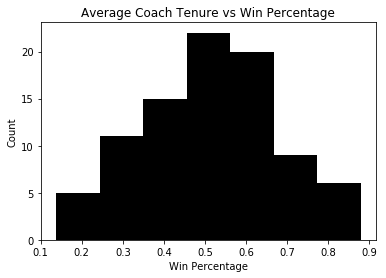

In [122]:
#plotting histogram of average coach tenure by wins
counts, bins, bars = plt.hist(tenuretable.Wins, bins = 7, color = 'black')
#set x-axis title
plt.xlabel('Win Percentage')
#set y-axis title
plt.ylabel('Count')
plt.show
#display bins
bins

Most of our coaches have win percentages of 50%.

In [113]:
#create empty lists labeled Bins 1-7
Bin1 = []
Bin2 = []
Bin3 = []
Bin4 = []
Bin5 = []
Bin6 = []
Bin7 = []
#for loop iterating through Wins column in coachtenuredf
for idx, x in enumerate(coachtenuredf.Wins):
    #if, elif statements if win percentage lies within the range of each bin from above histogram
    #append value to corresponding bin list
    if bins[0] <= x < bins[1]:
        Bin1.append(coachtenuredf.CoachTenure.iloc[idx])
    elif bins[1] <= x < bins[2]:
        Bin2.append(coachtenuredf.CoachTenure.iloc[idx])
    elif bins[2] <= x < bins[3]:
        Bin3.append(coachtenuredf.CoachTenure.iloc[idx])
    elif bins[3] <= x < bins[4]:
        Bin4.append(coachtenuredf.CoachTenure.iloc[idx])
    elif bins[4] <= x < bins[5]:
        Bin5.append(coachtenuredf.CoachTenure.iloc[idx])
    elif bins[5] <= x < bins[6]:
        Bin6.append(coachtenuredf.CoachTenure.iloc[idx])
    elif bins[6] <= x < bins[7]:
        Bin7.append(coachtenuredf.CoachTenure.iloc[idx])

#create empty dataframe
coachtenureav = pd.DataFrame()
#compute mean win percentage from each bins list and place value in empty dataframe
for x in range(7):
    coachtenureav.loc[x, 'Bins'] = x+1
    exec(f"coachtenureav.loc[{x}, 'Tenure'] = statistics.mean(Bin{x+1})")

In [127]:
#display coachtenureav dataframe
coachtenureav

,Bins,Tenure
0,1.0,718.871622
1,2.0,700.261168
2,3.0,815.692695
3,4.0,832.356608
4,5.0,965.093976
5,6.0,1108.676471
6,7.0,1279.081967


As the bin number increases, so does our win percentage, where bin 1 corresponds to about 20% and bin 7 corresponds to 82%. With the exception of bins 1 and 2, as the win percentage increases, our average coach tenure increases as well, having a difference of about 500 days or 4 seasons from bin 1 and bin 7.

<a id='crs'></a>

[Back to Top of Notebook](#toc)
## Computing Rolling Statistics

In the cells below, we compute most of our features for our train dataset. We must compute rolling averages for each team involved in a game, but the averages must only contain information from games played prior to this matchup. Therefore, we must keep a seperate tab of sum of statistics and total games played by each team, and input in our feature columns averages of games played before that specific matchup. We can do this using our teams dataframe, by first storing the averages in a row and then adding that row's results into our sum of statistics before moving onto the next row.

After we go through each season, we will be left with a teams dataframe consisting of sum of statistics for the whole season for each team. This will be used when making our test dataset, as the averages for each teams stats in our first round matchups will be of the whole season.

As we go through each row, we will also add our difference in coach tenure, difference in existence and difference in ordinal ranks to each row.

Remember, since we are only keeping total season averages for the prior three years, we don't need to compute and store rolling averages for 2014-2016 but only add the results to the sums.

In [254]:
def get_stats(test):
    
    '''Pass in season detailed results dataframe as an argument.
    get_stats function takes the structure of a void function, not returning a value.
    
    Function will iterate through a number of seasons, where for some values of seasons,
    it will iterate through the argument's rows (each corresponding to a specific game),
    computing new per game and advanced statistics and storing those values in a seperate dataframe (df20),
    while for other seasons,
    it will iterate through the argument's rows (each corresponding to a specific game) as well as other proxy dataframes,
    first placing rolling averages of both the winning and losing teams'
    past per game, advanced and random statistics in the argument,
    then will add that row's stats back into the seperate dataframe (df20) to update the rolling averages.
    
    End result will be a dataframe where rows correspond to unique games,
    and columns correspond to averages of statistics up to the date of that game or
    stats of that specific game.
    '''
    
    #for loop iterating through list of seasons 2014-2016
    for i in [2014, 2015, 2016]:
        #store zero values for rolling sums for each statistic
        df20['Wins' + str(i)] = 0
        df20['Losses' + str(i)] = 0
        df20['TmPoints' + str(i)] = 0
        df20['OppPoints' + str(i)] = 0        
        df20['Scorediff' + str(i)] = 0
        df20['2FG%diff' + str(i)] = 0
        df20['3FG%diff' + str(i)] = 0
        df20['FT%diff' + str(i)] = 0
        df20['2FGMdiff' + str(i)] = 0
        df20['3FGMdiff' + str(i)] = 0
        df20['FTMdiff' + str(i)] = 0
        df20['2FGAdiff' + str(i)] = 0
        df20['3FGAdiff' + str(i)] = 0
        df20['FTAdiff' + str(i)] = 0
        df20['ORdiff' + str(i)] = 0
        df20['DRdiff' + str(i)] = 0
        df20['TRdiff' + str(i)] = 0
        df20['Adiff' + str(i)] = 0
        df20['TOdiff' + str(i)] = 0
        df20['STdiff' + str(i)] = 0
        df20['BLKdiff' + str(i)] = 0
        df20['PFdiff' + str(i)] = 0
        df20['TS' + str(i)] = 0
        df20['Pace' + str(i)] = 0
        df20['ORTG' + str(i)] = 0        
        df20['DRTG' + str(i)] = 0
        df20['NRTG' + str(i)] = 0
        
        #create new dataframe where season equals the season we are currently using in for loop
        data = test[test.Season == i]
        #reset index
        data.reset_index(inplace = True)
        #save original index values
        data.rename(columns = {'index': 'bar'}, inplace = True)
        #assign first value in bar column as fakeindex variable
        fakeindex = data.bar[0]
        
        #for loop iterating through wins column in data dataframe
        for idx, x in enumerate(data.WTeamID):
            #find index of winning and losing teams in teams dataframe using team ID from data dataframe
            idxl = df20[df20['TeamID'] == data['LTeamID'].iloc[idx]].index.tolist()[0]
            idxw = df20[df20['TeamID'] == data['WTeamID'].iloc[idx]].index.tolist()[0]
            
            #compute total games played for winning and losing teams by adding total wins and losses for both
            gamesw = (df20['Wins' + str(i)].iloc[idxw] + df20['Losses' + str(i)].iloc[idxw])
            gamesl = (df20['Wins' + str(i)].iloc[idxl] + df20['Losses' + str(i)].iloc[idxl])

            #compute each per game, advanced, season statistic and add to teams dataframe (df20)
            #where the column in the teams dataframe corresponds to the statistic for a given year
            #for both the winning and losing teams
            df20.loc[idxw, 'Scorediff' + str(i)] += data['WScore'].iloc[idx] - data['LScore'].iloc[idx]
            df20.loc[idxw, '2FG%diff' + str(i)] += ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx])/(data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx])) - ((data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx])/(data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxw, '3FG%diff' + str(i)] += (data['WFGM3'].iloc[idx]/data['WFGA3'].iloc[idx]) - (data['LFGM3'].iloc[idx]/data['LFGA3'].iloc[idx])
            df20.loc[idxw, 'FT%diff' + str(i)] += (data['WFTM'].iloc[idx]/data['WFTA'].iloc[idx]) - (data['LFTM'].iloc[idx]/data['LFTA'].iloc[idx])
            df20.loc[idxw, '2FGMdiff' + str(i)] += ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx]) - (data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx]))
            df20.loc[idxw, '3FGMdiff' + str(i)] += (data['WFGM3'].iloc[idx] - data['LFGM3'].iloc[idx])
            df20.loc[idxw, 'FTMdiff' + str(i)] += (data['WFTM'].iloc[idx] - data['LFTM'].iloc[idx])
            df20.loc[idxw, '2FGAdiff' + str(i)] += ((data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx]) - (data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxw, '3FGAdiff' + str(i)] += (data['WFGA3'].iloc[idx] - data['LFGA3'].iloc[idx])
            df20.loc[idxw, 'FTAdiff' + str(i)] += (data['WFTA'].iloc[idx] - data['LFTA'].iloc[idx])
            df20.loc[idxw, 'ORdiff' + str(i)] += (data['WOR'].iloc[idx] - data['LOR'].iloc[idx])
            df20.loc[idxw, 'DRdiff' + str(i)] += (data['WDR'].iloc[idx] - data['LDR'].iloc[idx])
            df20.loc[idxw, 'TRdiff' + str(i)] += (data['WOR'].iloc[idx] + data['WDR'].iloc[idx]) - (data['LOR'].iloc[idx] + data['LDR'].iloc[idx])
            df20.loc[idxw, 'Adiff' + str(i)] += (data['WAst'].iloc[idx] - data['LAst'].iloc[idx])
            df20.loc[idxw, 'TOdiff' + str(i)] += (data['WTO'].iloc[idx] - data['LTO'].iloc[idx])
            df20.loc[idxw, 'STdiff' + str(i)] += (data['WStl'].iloc[idx] - data['LStl'].iloc[idx])
            df20.loc[idxw, 'BLKdiff' + str(i)] += (data['WBlk'].iloc[idx] - data['LBlk'].iloc[idx])
            df20.loc[idxw, 'PFdiff' + str(i)] += (data['WPF'].iloc[idx] - data['LPF'].iloc[idx])
            df20.loc[idxw, 'Wins' + str(i)] += 1
            df20.loc[idxw, 'TmPoints' + str(i)] += data.WScore[idx]
            df20.loc[idxw, 'OppPoints' + str(i)] += data.LScore[idx]
            df20.loc[idxw, 'TS' + str(i)] += data.WScore.iloc[idx]/(2*(data.WFGA.iloc[idx]+(0.475*data.WFTA.iloc[idx])))
            poss = (0.5*(data.WFGA.iloc[idx]+(0.475*data.WFTA.iloc[idx])-data.WOR.iloc[idx]+data.WTO.iloc[idx]))+0.5*(data.LFGA.iloc[idx]+(0.475*data.LFTA.iloc[idx])-data.LOR.iloc[idx]+data.LTO.iloc[idx])
            df20.loc[idxw, 'Pace' + str(i)] += 40*(poss/(0.2*(40 + (data.NumOT.iloc[idx]*5))))
            df20.loc[idxw, 'ORTG' + str(i)] += data.WScore.iloc[idx] / poss
            df20.loc[idxw, 'DRTG' + str(i)] += data.LScore.iloc[idx] / poss
            df20.loc[idxw, 'NRTG' + str(i)] += (data.WScore.iloc[idx] / poss) - (data.LScore.iloc[idx] / poss)

            df20.loc[idxl, 'Scorediff' + str(i)] += -1 * (data['WScore'].iloc[idx] - data['LScore'].iloc[idx])
            df20.loc[idxl, '2FG%diff' + str(i)] += -1 * ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx])/(data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx])) - ((data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx])/(data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxl, '3FG%diff' + str(i)] += -1 * (data['WFGM3'].iloc[idx]/data['WFGA3'].iloc[idx]) - (data['LFGM3'].iloc[idx]/data['LFGA3'].iloc[idx])
            df20.loc[idxl, 'FT%diff' + str(i)] += -1 * (data['WFTM'].iloc[idx]/data['WFTA'].iloc[idx]) - (data['LFTM'].iloc[idx]/data['LFTA'].iloc[idx])
            df20.loc[idxl, '2FGMdiff' + str(i)] += -1 * ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx]) - (data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx]))
            df20.loc[idxl, '3FGMdiff' + str(i)] += -1 * (data['WFGM3'].iloc[idx] - data['LFGM3'].iloc[idx])
            df20.loc[idxl, 'FTMdiff' + str(i)] += -1 * (data['WFTM'].iloc[idx] - data['LFTM'].iloc[idx])
            df20.loc[idxl, '2FGAdiff' + str(i)] += -1 * ((data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx]) - (data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxl, '3FGAdiff' + str(i)] += -1 * (data['WFGA3'].iloc[idx] - data['LFGA3'].iloc[idx])
            df20.loc[idxl, 'FTAdiff' + str(i)] += -1 * (data['WFTA'].iloc[idx] - data['LFTA'].iloc[idx])
            df20.loc[idxl, 'ORdiff' + str(i)] += -1 * (data['WOR'].iloc[idx] - data['LOR'].iloc[idx])
            df20.loc[idxl, 'DRdiff' + str(i)] += -1 * (data['WDR'].iloc[idx] - data['LDR'].iloc[idx])
            df20.loc[idxl, 'TRdiff' + str(i)] += -1 * (data['WOR'].iloc[idx] + data['WDR'].iloc[idx]) - (data['LOR'].iloc[idx] + data['LDR'].iloc[idx])
            df20.loc[idxl, 'Adiff' + str(i)] += -1 * (data['WAst'].iloc[idx] - data['LAst'].iloc[idx])
            df20.loc[idxl, 'TOdiff' + str(i)] += -1 * (data['WTO'].iloc[idx] - data['LTO'].iloc[idx])
            df20.loc[idxl, 'STdiff' + str(i)] += -1 * (data['WStl'].iloc[idx] - data['LStl'].iloc[idx])
            df20.loc[idxl, 'BLKdiff' + str(i)] += -1 * (data['WBlk'].iloc[idx] - data['LBlk'].iloc[idx])
            df20.loc[idxl, 'PFdiff' + str(i)] += -1 * (data['WPF'].iloc[idx] - data['LPF'].iloc[idx])
            df20.loc[idxl, 'Losses' + str(i)] += 1
            df20.loc[idxl, 'TmPoints' + str(i)] += data.LScore[idx]
            df20.loc[idxl, 'OppPoints' + str(i)] += data.WScore[idx]
            df20.loc[idxl, 'TS' + str(i)] += data.LScore.iloc[idx]/(2*(data.LFGA.iloc[idx]+(0.475*data.LFTA.iloc[idx])))
            df20.loc[idxl, 'Pace' + str(i)] += 40*(poss/(0.2*(40 + (data.NumOT.iloc[idx]*5))))
            df20.loc[idxl, 'ORTG' + str(i)] += data.LScore.iloc[idx] / poss
            df20.loc[idxl, 'DRTG' + str(i)] += data.WScore.iloc[idx] / poss
            df20.loc[idxl, 'NRTG' + str(i)] += (data.LScore.iloc[idx] / poss) - (data.WScore.iloc[idx] / poss)
            
            #print index value to keep track of which row we are working on
            print(idx + fakeindex)        
    
    #for loop iterating through list of seasons 2017-2019
    for i in [2017, 2018, 2019]:
        #store zero values for rolling sums for each statistic
        df20['Wins' + str(i)] = 0
        df20['Losses' + str(i)] = 0
        df20['TmPoints' + str(i)] = 0
        df20['OppPoints' + str(i)] = 0
        df20['Scorediff' + str(i)] = 0
        df20['2FG%diff' + str(i)] = 0
        df20['3FG%diff' + str(i)] = 0
        df20['FT%diff' + str(i)] = 0
        df20['2FGMdiff' + str(i)] = 0
        df20['3FGMdiff' + str(i)] = 0
        df20['FTMdiff' + str(i)] = 0
        df20['2FGAdiff' + str(i)] = 0
        df20['3FGAdiff' + str(i)] = 0
        df20['FTAdiff' + str(i)] = 0
        df20['ORdiff' + str(i)] = 0
        df20['DRdiff' + str(i)] = 0
        df20['TRdiff' + str(i)] = 0
        df20['Adiff' + str(i)] = 0
        df20['TOdiff' + str(i)] = 0
        df20['STdiff' + str(i)] = 0
        df20['BLKdiff' + str(i)] = 0
        df20['PFdiff' + str(i)] = 0
        df20['TS' + str(i)] = 0
        df20['Pace' + str(i)] = 0
        df20['ORTG' + str(i)] = 0        
        df20['DRTG' + str(i)] = 0
        df20['NRTG' + str(i)] = 0
         
        #create new dataframe where season equals the season we are currently using in for loop
        data = test[test.Season == i]
        #reset index
        data.reset_index(inplace = True)
        #save original index values as column
        data.rename(columns = {'index': 'bar'}, inplace = True)
        #assign first value in bar column as fakeindex variable
        fakeindex = data.bar[0]
        
        #for loop iterating through winning team id column in data dataframe
        for idx, x in enumerate(data.WTeamID):
            #find index of winning and losing teams in teams dataframe using team ID from data dataframe
            idxl = df20[df20['TeamID'] == data['LTeamID'].iloc[idx]].index.tolist()[0]
            idxw = df20[df20['TeamID'] == data['WTeamID'].iloc[idx]].index.tolist()[0]

            #compute total games played for winning and losing team by adding total wins and losses for both
            gamesw = (df20['Wins' + str(i)].iloc[idxw] + df20['Losses' + str(i)].iloc[idxw])
            gamesl = (df20['Wins' + str(i)].iloc[idxl] + df20['Losses' + str(i)].iloc[idxl])

            #store average of per game, advanced, season statistic in argument dataframe using
            #sum of statistics for given season in teams dataframe (df20) and total games played
            #for both winning and losing teams
            test.loc[idx + fakeindex, 'WScorediff'] = 0 if gamesw == 0 else df20['Scorediff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'W2FG%diff'] = 0 if gamesw == 0 else df20['2FG%diff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'W3FG%diff'] = 0 if gamesw == 0 else df20['3FG%diff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WFT%diff'] = 0 if gamesw == 0 else df20['FT%diff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'W2FGMdiff'] = 0 if gamesw == 0 else df20['2FGMdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'W3FGMdiff'] = 0 if gamesw == 0 else df20['3FGMdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WFTMdiff'] = 0 if gamesw == 0 else df20['FTMdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'W2FGAdiff'] = 0 if gamesw == 0 else df20['2FGAdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'W3FGAdiff'] = 0 if gamesw == 0 else df20['3FGAdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WFTAdiff'] = 0 if gamesw == 0 else df20['FTAdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WORdiff'] = 0 if gamesw == 0 else df20['ORdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WDRdiff'] = 0 if gamesw == 0 else df20['DRdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WTRdiff'] = 0 if gamesw == 0 else df20['TRdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WAdiff'] = 0 if gamesw == 0 else df20['Adiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WTOdiff'] = 0 if gamesw == 0 else df20['TOdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WSTdiff'] = 0 if gamesw == 0 else df20['STdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WBLKdiff'] = 0 if gamesw == 0 else df20['BLKdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WPFdiff'] = 0 if gamesw == 0 else df20['PFdiff' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WTS'] = 0 if gamesw == 0 else df20['TS' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WPace'] = 0 if gamesw == 0 else df20['Pace' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WORTG'] = 0 if gamesw == 0 else df20['ORTG' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WDRTG'] = 0 if gamesw == 0 else df20['DRTG' + str(i)].iloc[idxw]/gamesw
            test.loc[idx + fakeindex, 'WNRTG'] = 0 if gamesw == 0 else df20['NRTG' + str(i)].iloc[idxw]/gamesw
                        
            test.loc[idx + fakeindex, 'LScorediff'] = 0 if gamesl == 0 else df20['Scorediff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'L2FG%diff'] = 0 if gamesl == 0 else df20['2FG%diff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'L3FG%diff'] = 0 if gamesl == 0 else df20['3FG%diff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LFT%diff'] = 0 if gamesl == 0 else df20['FT%diff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'L2FGMdiff'] = 0 if gamesl == 0 else df20['2FGMdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'L3FGMdiff'] = 0 if gamesl == 0 else df20['3FGMdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LFTMdiff'] = 0 if gamesl == 0 else df20['FTMdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'L2FGAdiff'] = 0 if gamesl == 0 else df20['2FGAdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'L3FGAdiff'] = 0 if gamesl == 0 else df20['3FGAdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LFTAdiff'] = 0 if gamesl == 0 else df20['FTAdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LORdiff'] = 0 if gamesl == 0 else df20['ORdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LDRdiff'] = 0 if gamesl == 0 else df20['DRdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LTRdiff'] = 0 if gamesl == 0 else df20['TRdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LAdiff'] = 0 if gamesl == 0 else df20['Adiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LTOdiff'] = 0 if gamesl == 0 else df20['TOdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LSTdiff'] = 0 if gamesl == 0 else df20['STdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LBLKdiff'] = 0 if gamesl == 0 else df20['BLKdiff' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LPFdiff'] = 0 if gamesl == 0 else df20['PFdiff' + str(i)].iloc[idxl]/gamesl            
            test.loc[idx + fakeindex, 'LTS'] = 0 if gamesw == 0 else df20['TS' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LPace'] = 0 if gamesw == 0 else df20['Pace' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LORTG'] = 0 if gamesw == 0 else df20['ORTG' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LDRTG'] = 0 if gamesw == 0 else df20['DRTG' + str(i)].iloc[idxl]/gamesl
            test.loc[idx + fakeindex, 'LNRTG'] = 0 if gamesw == 0 else df20['NRTG' + str(i)].iloc[idxl]/gamesl            
            test.loc[idx + fakeindex, 'WTmPoints'] = df20['TmPoints' + str(i)][idxw]
            test.loc[idx + fakeindex, 'WOppPoints'] = df20['OppPoints' + str(i)][idxw]
            test.loc[idx + fakeindex, 'LTmPoints'] = df20['TmPoints' + str(i)][idxl]
            test.loc[idx + fakeindex, 'LOppPoints'] = df20['OppPoints' + str(i)][idxl]

            test.loc[idx + fakeindex, 'WWinsCount'] = df20['Wins' + str(i)].iloc[idxw]
            test.loc[idx + fakeindex, 'LWinsCount'] = df20['Wins' + str(i)].iloc[idxl]
            test.loc[idx + fakeindex, 'WLossesCount'] = df20['Losses' + str(i)].iloc[idxw]
            test.loc[idx + fakeindex, 'LLossesCount'] = df20['Losses' + str(i)].iloc[idxl]
            test.loc[idx + fakeindex, 'WWPyth'] = 0 if gamesw == 0 else (gamesw * (math.pow(df20['TmPoints' + str(i)][idxw],  9) / sum([math.pow(df20['TmPoints' + str(i)][idxw],  9), math.pow(df20['OppPoints' + str(i)][idxw],  9)])))
            test.loc[idx + fakeindex, 'LWPyth'] = 0 if gamesl == 0 else (gamesl * (math.pow(df20['TmPoints' + str(i)][idxl],  9) / sum([math.pow(df20['TmPoints' + str(i)][idxl],  9), math.pow(df20['OppPoints' + str(i)][idxl],  9)])))
            test.loc[idx + fakeindex, 'WRealWinsDiff'] = test.WWinsCount.iloc[idx + fakeindex] - test.WWPyth.iloc[idx + fakeindex]
            test.loc[idx + fakeindex, 'LRealWinsDiff'] = test.LWinsCount.iloc[idx + fakeindex] - test.LWPyth.iloc[idx + fakeindex]

            #using season column, where values equal length of being a DI program,
            #store the difference in argument dataframe
            test.loc[idx + fakeindex, 'Existencediff'] = df20[str(data.Season[idx])][idxw] - df20[str(data.Season[idx])][idxl]

            #create proxy dataframe of rating system dataframe where season equals season for the row currently on
            proxy = df17[df17['Season'] == data.Season[idx]]
            #restrict RankingDayNum to less than or equal to current DayNum value in row currently on
            proxy = proxy[proxy['RankingDayNum'] <= data['DayNum'][idx]]
            #create new proxy win and lose dataframes for winning and losing teams
            proxyw = proxy[proxy['TeamID'] == x]
            proxyl = proxy[proxy['TeamID'] == data['LTeamID'][idx]]
            #pass if either dataframes are empty
            if proxyw.empty == True:
                pass
            elif proxyl.empty == True:
                pass
            #if both not empty, take difference of averages of most recent days ranking values for the two teams
            else:
                proxyw = proxyw[proxyw['RankingDayNum'] == proxyw['RankingDayNum'].iloc[-1]]
                proxyl = proxyl[proxyl['RankingDayNum'] == proxyl['RankingDayNum'].iloc[-1]]
                #store rank difference value in argument dataframe
                test.loc[idx + fakeindex, 'Rankdiff'] = proxyl.OrdinalRank.mean() - proxyw.OrdinalRank.mean()

            #if, elif statements checking location of game and storing in new binary categorical columns
            if data.WLoc.iloc[idx] == 'H':
                test.loc[idx + fakeindex, 'WH'] = 1
                test.loc[idx + fakeindex, 'WA'] = 0
                test.loc[idx + fakeindex, 'WN'] = 0
                test.loc[idx + fakeindex, 'LH'] = 0
                test.loc[idx + fakeindex, 'LA'] = 1
                test.loc[idx + fakeindex, 'LN'] = 0
            elif data.WLoc.iloc[idx] == 'A':
                test.loc[idx + fakeindex, 'WH'] = 0
                test.loc[idx + fakeindex, 'WA'] = 1
                test.loc[idx + fakeindex, 'WN'] = 0
                test.loc[idx + fakeindex, 'LH'] = 1
                test.loc[idx + fakeindex, 'LA'] = 0
                test.loc[idx + fakeindex, 'LN'] = 0
            elif data.WLoc.iloc[idx] == 'N':
                test.loc[idx + fakeindex, 'WH'] = 0
                test.loc[idx + fakeindex, 'WA'] = 0
                test.loc[idx + fakeindex, 'WN'] = 1
                test.loc[idx + fakeindex, 'LH'] = 0
                test.loc[idx + fakeindex, 'LA'] = 0
                test.loc[idx + fakeindex, 'LN'] = 1

            #create new proxy dataframe of coach dataframe where season values are equals season
            #for the row we are currently on
            coachdiff = df15[df15['Season'] == data['Season'][idx]]
            #new winning and losing teams dataframes made from coach proxy dataframe
            coachdiffw = coachdiff[coachdiff['TeamID'] == x]
            coachdiffl = coachdiff[coachdiff['TeamID'] == data['LTeamID'][idx]]

            #for loop iterating through LastDayNum values in winning coach dataframe
            for r, s in enumerate(coachdiffw.LastDayNum):
                #pass if DayNum of row currently on is greater than coaches Last Day as coach for that season
                if data.DayNum.iloc[idx] > s:
                    pass
                #assign daysw with number of days as coach of that program
                #if DayNum of row currently on is less than or equals coaches Last Day as coach for that season
                elif data.DayNum.iloc[idx] <= s:
                    daysw = coachdiffw.CoachTenure.iloc[r] - (s - data.DayNum.iloc[idx])
                    
            #for loop iterating through LastDayNum values in losing coach dataframe
            for r, s in enumerate(coachdiffl.LastDayNum):
                #pass if DayNum of row currently on is greater than coaches Last Day as coach for that season
                if data.DayNum.iloc[idx] > s:
                    pass
                #assign daysl with number of days as coach of that program
                #if DayNum of row currently on is less than or equals coaches Last Day as coach for that season
                elif data.DayNum.iloc[idx] <= s:
                    daysl = coachdiffl.CoachTenure.iloc[r] - (s - data.DayNum.iloc[idx])

            #store difference in daysw and daysl in argument dataframe
            test.loc[idx + fakeindex, 'Coachdiff'] = daysw - daysl
            
            #compute each per game, advanced, season statistic and add to teams dataframe (df20)
            #where the column in the teams dataframe corresponds to the statistic for a given year
            #for both winning and losing teams
            df20.loc[idxw, 'Scorediff' + str(i)] += data['WScore'].iloc[idx] - data['LScore'].iloc[idx]
            df20.loc[idxw, '2FG%diff' + str(i)] += ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx])/(data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx])) - ((data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx])/(data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxw, '3FG%diff' + str(i)] += (data['WFGM3'].iloc[idx]/data['WFGA3'].iloc[idx]) - (data['LFGM3'].iloc[idx]/data['LFGA3'].iloc[idx])
            df20.loc[idxw, 'FT%diff' + str(i)] += (data['WFTM'].iloc[idx]/data['WFTA'].iloc[idx]) - (data['LFTM'].iloc[idx]/data['LFTA'].iloc[idx])
            df20.loc[idxw, '2FGMdiff' + str(i)] += ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx]) - (data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx]))
            df20.loc[idxw, '3FGMdiff' + str(i)] += (data['WFGM3'].iloc[idx] - data['LFGM3'].iloc[idx])
            df20.loc[idxw, 'FTMdiff' + str(i)] += (data['WFTM'].iloc[idx] - data['LFTM'].iloc[idx])
            df20.loc[idxw, '2FGAdiff' + str(i)] += ((data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx]) - (data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxw, '3FGAdiff' + str(i)] += (data['WFGA3'].iloc[idx] - data['LFGA3'].iloc[idx])
            df20.loc[idxw, 'FTAdiff' + str(i)] += (data['WFTA'].iloc[idx] - data['LFTA'].iloc[idx])
            df20.loc[idxw, 'ORdiff' + str(i)] += (data['WOR'].iloc[idx] - data['LOR'].iloc[idx])
            df20.loc[idxw, 'DRdiff' + str(i)] += (data['WDR'].iloc[idx] - data['LDR'].iloc[idx])
            df20.loc[idxw, 'TRdiff' + str(i)] += (data['WOR'].iloc[idx] + data['WDR'].iloc[idx]) - (data['LOR'].iloc[idx] + data['LDR'].iloc[idx])
            df20.loc[idxw, 'Adiff' + str(i)] += (data['WAst'].iloc[idx] - data['LAst'].iloc[idx])
            df20.loc[idxw, 'TOdiff' + str(i)] += (data['WTO'].iloc[idx] - data['LTO'].iloc[idx])
            df20.loc[idxw, 'STdiff' + str(i)] += (data['WStl'].iloc[idx] - data['LStl'].iloc[idx])
            df20.loc[idxw, 'BLKdiff' + str(i)] += (data['WBlk'].iloc[idx] - data['LBlk'].iloc[idx])
            df20.loc[idxw, 'PFdiff' + str(i)] += (data['WPF'].iloc[idx] - data['LPF'].iloc[idx])
            df20.loc[idxw, 'Wins' + str(i)] += 1
            df20.loc[idxw, 'TmPoints' + str(i)] += data.WScore[idx]
            df20.loc[idxw, 'OppPoints' + str(i)] += data.LScore[idx]
            df20.loc[idxw, 'TS' + str(i)] += data.WScore.iloc[idx]/(2*(data.WFGA.iloc[idx]+(0.475*data.WFTA.iloc[idx])))
            poss = (0.5*(data.WFGA.iloc[idx]+(0.475*data.WFTA.iloc[idx])-data.WOR.iloc[idx]+data.WTO.iloc[idx]))+0.5*(data.LFGA.iloc[idx]+(0.475*data.LFTA.iloc[idx])-data.LOR.iloc[idx]+data.LTO.iloc[idx])
            df20.loc[idxw, 'Pace' + str(i)] += 40*(poss/(0.2*(40 + (data.NumOT.iloc[idx]*5))))
            df20.loc[idxw, 'ORTG' + str(i)] += data.WScore.iloc[idx] / poss
            df20.loc[idxw, 'DRTG' + str(i)] += data.LScore.iloc[idx] / poss
            df20.loc[idxw, 'NRTG' + str(i)] += (data.WScore.iloc[idx] / poss) - (data.LScore.iloc[idx] / poss)

            df20.loc[idxl, 'Scorediff' + str(i)] += -1 * (data['WScore'].iloc[idx] - data['LScore'].iloc[idx])
            df20.loc[idxl, '2FG%diff' + str(i)] += -1 * ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx])/(data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx])) - ((data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx])/(data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxl, '3FG%diff' + str(i)] += -1 * (data['WFGM3'].iloc[idx]/data['WFGA3'].iloc[idx]) - (data['LFGM3'].iloc[idx]/data['LFGA3'].iloc[idx])
            df20.loc[idxl, 'FT%diff' + str(i)] += -1 * (data['WFTM'].iloc[idx]/data['WFTA'].iloc[idx]) - (data['LFTM'].iloc[idx]/data['LFTA'].iloc[idx])
            df20.loc[idxl, '2FGMdiff' + str(i)] += -1 * ((data['WFGM'].iloc[idx] - data['WFGM3'].iloc[idx]) - (data['LFGM'].iloc[idx] - data['LFGM3'].iloc[idx]))
            df20.loc[idxl, '3FGMdiff' + str(i)] += -1 * (data['WFGM3'].iloc[idx] - data['LFGM3'].iloc[idx])
            df20.loc[idxl, 'FTMdiff' + str(i)] += -1 * (data['WFTM'].iloc[idx] - data['LFTM'].iloc[idx])
            df20.loc[idxl, '2FGAdiff' + str(i)] += -1 * ((data['WFGA'].iloc[idx] - data['WFGA3'].iloc[idx]) - (data['LFGA'].iloc[idx] - data['LFGA3'].iloc[idx]))
            df20.loc[idxl, '3FGAdiff' + str(i)] += -1 * (data['WFGA3'].iloc[idx] - data['LFGA3'].iloc[idx])
            df20.loc[idxl, 'FTAdiff' + str(i)] += -1 * (data['WFTA'].iloc[idx] - data['LFTA'].iloc[idx])
            df20.loc[idxl, 'ORdiff' + str(i)] += -1 * (data['WOR'].iloc[idx] - data['LOR'].iloc[idx])
            df20.loc[idxl, 'DRdiff' + str(i)] += -1 * (data['WDR'].iloc[idx] - data['LDR'].iloc[idx])
            df20.loc[idxl, 'TRdiff' + str(i)] += -1 * (data['WOR'].iloc[idx] + data['WDR'].iloc[idx]) - (data['LOR'].iloc[idx] + data['LDR'].iloc[idx])
            df20.loc[idxl, 'Adiff' + str(i)] += -1 * (data['WAst'].iloc[idx] - data['LAst'].iloc[idx])
            df20.loc[idxl, 'TOdiff' + str(i)] += -1 * (data['WTO'].iloc[idx] - data['LTO'].iloc[idx])
            df20.loc[idxl, 'STdiff' + str(i)] += -1 * (data['WStl'].iloc[idx] - data['LStl'].iloc[idx])
            df20.loc[idxl, 'BLKdiff' + str(i)] += -1 * (data['WBlk'].iloc[idx] - data['LBlk'].iloc[idx])
            df20.loc[idxl, 'PFdiff' + str(i)] += -1 * (data['WPF'].iloc[idx] - data['LPF'].iloc[idx])
            df20.loc[idxl, 'Losses' + str(i)] += 1
            df20.loc[idxl, 'TmPoints' + str(i)] += data.LScore[idx]
            df20.loc[idxl, 'OppPoints' + str(i)] += data.WScore[idx]
            df20.loc[idxl, 'TS' + str(i)] += data.LScore.iloc[idx]/(2*(data.LFGA.iloc[idx]+(0.475*data.LFTA.iloc[idx])))
            df20.loc[idxl, 'Pace' + str(i)] += 40*(poss/(0.2*(40 + (data.NumOT.iloc[idx]*5))))
            df20.loc[idxl, 'ORTG' + str(i)] += data.LScore.iloc[idx] / poss
            df20.loc[idxl, 'DRTG' + str(i)] += data.WScore.iloc[idx] / poss
            df20.loc[idxl, 'NRTG' + str(i)] += (data.LScore.iloc[idx] / poss) - (data.WScore.iloc[idx] / poss)
            
            #print index value to keep track of which row we are working on
            print(idx + fakeindex)

In [ ]:
#run get_stats on df dataframe made earlier
get_stats(df)

In [256]:
#display team dataframe
display(df20)
#display first 5 rows of df
df.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,2014,2015,2016,2017,2018,2019,...,Adiff2019,TOdiff2019,STdiff2019,BLKdiff2019,PFdiff2019,TS2019,Pace2019,ORTG2019,DRTG2019,NRTG2019
0,1101,Abilene Chr,2014,2020,0.0,1.0,2.0,3.0,4.0,5.0,...,102,-118,71,-12,31,16.191316,9733.562500,31.059481,28.056502,3.002980
1,1102,Air Force,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,-24,32,-72,-28,-7,16.734795,10598.250000,30.618312,32.761546,-2.143235
2,1103,Akron,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,53,-37,-4,15,-1,15.983116,10654.000000,30.814552,29.133766,1.680786
3,1104,Alabama,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,27,57,-57,12,-68,17.633621,11530.250000,33.810603,33.725482,0.085121
4,1105,Alabama A&M,2000,2020,14.0,15.0,16.0,17.0,18.0,19.0,...,-50,29,-12,-60,124,15.434484,10905.937500,28.460432,33.614364,-5.153932
5,1106,Alabama St,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,-121,-5,-32,-12,-36,14.395397,10004.750000,27.632846,30.788551,-3.155705
6,1107,SUNY Albany,2000,2020,14.0,15.0,16.0,17.0,18.0,19.0,...,-57,50,-10,-36,17,16.536282,10431.687500,30.770797,31.996965,-1.226168
7,1108,Alcorn St,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,-131,107,-43,17,60,13.261590,9141.312500,24.104419,29.208648,-5.104229
8,1109,Alliant Intl,1985,1991,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
9,1110,American Univ,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,27,20,30,33,-6,16.895844,10321.000000,31.384768,30.048026,1.336742


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LRealWinsDiff,Existencediff,WH,WA,WN,LH,LA,LN,Coachdiff,Rankdiff
0,2014,4,1102,79,1119,68,N,0,26,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,4,1103,72,1157,63,H,0,25,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,4,1107,74,1373,62,A,0,21,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,4,1112,73,1142,62,H,0,24,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,4,1113,96,1420,61,H,0,27,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
#serializing dataframes
df.to_pickle("finisheddata.pkl")
df20.to_pickle("previousstats.pkl")

<a id='cres'></a>

[Back to Top of Notebook](#toc)
## Computing Rolling Event Stats

In the cells below, we compute the average shooting percentages of first 5, last 5 minutes of each half of previous games for each team involved in the game. Unfortunately, I combined events including the game itself, so later when we build our train and test datasets, we will place the values in the rows accordingly so that averages do not include results from the game itself. An easy fix would be to change the restriction on the first proxy dataframe in the function to DayNum being strictly less than the DayNum of the game, but due to a long runtime, we will fix this issue later.

In order to compute shooting percentages, we combine event types for intervals relating to the first 5, last 5 minutes of each half, and then counting the number of made and missed shots to compute the shooting percentages.

In order to keep our data seperate, we will make copies of our dataframe for each seperate season 2017-2019.

In [6]:
def get_event_stats(data, data2):
    
    '''Arguments are two dataframes, the first being a dataframe where each row corresponds to a specific game,
    and the second being the individual game events where the rows correspond to a unique event.
    Returns first dataframe where each row corresponds to a specific game but now with shooting percentages
    of first five, last five minutes of first and second halves.
    
    Function will iterate through winning team ID in the first dataframe,
    where each row is each specific game.
    For each row, function will create a winning and losing dataframe for the teams involved in the game,
    for all days on and before the day of the game.
    Then, the function will group events in the first five and last five minutes of the first and second halves,
    and compute 2 point field goal percentage, 3 point field goal percentage and free throw percentage.
    It will finish by storing those values in the first dataframe.
    '''
    
    #for loop iterating through winning team id column in data dataframe
    for idx, x in enumerate(data.WTeamID):
        #create winning team and losing team proxy dataframes where DayNum is equal or less than DayNum of current row
        proxy = data2[data2.DayNum <= data.DayNum.iloc[idx]]
        proxyw = proxy[proxy.EventTeamID == x]
        proxyl = proxy[proxy.EventTeamID == data.LTeamID.iloc[idx]]

        #assign name variable value to 1
        name = 1
        #for loop iterating through lists of intervals referring to ElapsedSeconds column in data dataframe
        for i in [[0,299] , [900, 1199], [1200, 1599], [2100, 2399]]:
            #new winning and losing team dataframes where ElapsedSeconds is restricted between the current interval
            w = proxyw[proxyw.ElapsedSeconds >= i[0]]
            l = proxyl[proxyl.ElapsedSeconds >= i[0]]

            w = w[w.ElapsedSeconds <= i[1]]
            l = l[l.ElapsedSeconds <= i[1]]
            
            #pass if either w or l proxy dataframes is empty
            if (w.empty == True) or (l.empty == True):
                pass
            else:
                #grouping sum of EventTypes by ElapsedSeconds
                w = w.groupby(['EventTeamID', 'ElapsedSeconds']).agg({'EventType':['sum']}).reset_index()
                #rename columns in groupby dataframe
                w.columns = ['WTeamID', 'ElapsedSeconds', 'EventType']

                #grouping sum of EventTypes by ElapsedSeconds
                l = l.groupby(['EventTeamID', 'ElapsedSeconds']).agg({'EventType':['sum']}).reset_index()
                #rename columns in groupby dataframe
                l.columns = ['LTeamID', 'ElapsedSeconds', 'EventType']

                #assign variables to zero for future count of events
                two = 0
                three = 0
                ft = 0
                twomiss = 0
                threemiss = 0
                ftmiss = 0

                #for loop iterating through EventType in winning groupby dataframe
                for k in w.EventType:
                    #add count of event type to corresponding variables
                    two += k.count('made2')
                    three += k.count('made3')
                    ft += k.count('made1')
                    twomiss += k.count('miss2')
                    threemiss += k.count('miss3')
                    ftmiss += k.count('miss1')

                #store shooting percentages for winning team for specific interval
                data.loc[idx, 'W2%' + str(name)] = 0 if (two + twomiss) == 0 else (two/(two + twomiss))
                data.loc[idx, 'W3%' + str(name)] = 0 if (three + threemiss) == 0 else (three/(three + threemiss))
                data.loc[idx, 'WFT' + str(name)] = 0 if (ft + ftmiss) == 0 else (ft/(ft + ftmiss))

                #assign variables to zero for future count of events
                two = 0
                three = 0
                ft = 0
                twomiss = 0
                threemiss = 0
                ftmiss = 0

                #for loop iterating through EventType in losing groupby dataframe
                for k in l.EventType:
                    #add count of event type to corresponding variables
                    two += k.count('made2')
                    three += k.count('made3')
                    ft += k.count('made1')
                    twomiss += k.count('miss2')
                    threemiss += k.count('miss3')
                    ftmiss += k.count('miss1')

                #store shooting percentages for winning team for specific interval
                data.loc[idx, 'L2%' + str(name)] = 0 if (two + twomiss) == 0 else (two/(two + twomiss))
                data.loc[idx, 'L3%' + str(name)] = 0 if (three + threemiss) == 0 else (three/(three + threemiss))
                data.loc[idx, 'LFT' + str(name)] = 0 if (ft + ftmiss) == 0 else (ft/(ft + ftmiss))

                #add 1 to name variable
                name += 1

    #return original dataframe    
    return data

In [14]:
#create new dataframe from df dataframe where season is restricted to 2019
example2 = df[df.Season == 2017]
#reset index
example2.reset_index(inplace = True)
#save original indices for later
example2.rename(columns = {'index': 'bar'}, inplace = True)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [15]:
#run get_events_stats function on 2017 dataframe and 2017 events dataframe
get_event_stats(example2, df16)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,bar,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,...,WFT3,L2%3,L3%3,LFT3,W2%4,W3%4,WFT4,L2%4,L3%4,LFT4
0,26658,2017,11,1104,70,1157,53,H,0,21,...,0.750000,0.000000,0.333333,0.800000,0.666667,1.000000,0.750000,0.166667,0.500000,0.000000
1,26659,2017,11,1107,87,1336,81,A,0,30,...,1.000000,0.166667,0.428571,0.000000,0.750000,0.000000,0.777778,1.000000,0.200000,1.000000
2,26660,2017,11,1112,65,1277,63,N,0,20,...,0.666667,0.666667,0.666667,0.000000,0.714286,0.000000,0.000000,0.666667,0.166667,0.000000
3,26661,2017,11,1113,88,1340,70,H,0,33,...,0.600000,0.375000,0.500000,1.000000,1.000000,0.250000,0.666667,0.750000,0.000000,1.000000
4,26662,2017,11,1116,92,1236,83,H,0,35,...,0.333333,0.300000,0.000000,0.666667,0.833333,0.333333,0.666667,0.666667,0.333333,1.000000
5,26663,2017,11,1120,83,1316,66,H,0,25,...,0.666667,0.400000,0.000000,0.500000,0.666667,0.000000,1.000000,1.000000,0.000000,0.500000
6,26664,2017,11,1123,85,1387,64,A,0,30,...,1.000000,0.666667,0.333333,1.000000,1.000000,0.333333,1.000000,0.857143,0.000000,1.000000
7,26665,2017,11,1124,76,1331,61,H,0,24,...,0.500000,0.666667,0.000000,0.500000,0.166667,0.500000,0.875000,0.666667,0.333333,1.000000
8,26666,2017,11,1127,68,1165,62,H,0,23,...,0.000000,0.500000,0.000000,0.000000,1.000000,1.000000,0.533333,0.285714,0.250000,0.700000
9,26667,2017,11,1137,76,1264,64,H,0,25,...,0.750000,0.200000,0.666667,0.000000,0.800000,1.000000,0.625000,1.000000,0.333333,1.000000


In [16]:
#serializing dataframe
example2.to_pickle("2017events.pkl")

In [17]:
#create new dataframe from df dataframe where season is restricted to 2019
example3 = df[df.Season == 2018]
#reset index
example3.reset_index(inplace = True)
#save original indices for later
example3.rename(columns = {'index': 'bar'}, inplace = True)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [18]:
#run get_events_stats function on 2018 dataframe and 2018 events dataframe
get_event_stats(example3, df3)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,bar,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,...,WFT3,L2%3,L3%3,LFT3,W2%4,W3%4,WFT4,L2%4,L3%4,LFT4
0,32053,2018,11,1104,82,1272,70,N,0,26,...,0.500000,0.833333,0.000000,0.750000,0.000000,0.250000,0.833333,0.428571,0.250000,0.500000
1,32054,2018,11,1107,69,1233,67,H,0,24,...,0.000000,0.777778,0.000000,1.000000,0.400000,1.000000,0.909091,0.666667,0.000000,0.857143
2,32055,2018,11,1112,101,1319,67,H,0,34,...,1.000000,0.444444,0.333333,1.000000,1.000000,0.333333,1.000000,0.000000,0.333333,0.750000
3,32056,2018,11,1113,94,1226,74,H,0,34,...,0.875000,0.428571,1.000000,0.500000,0.000000,0.333333,1.000000,1.000000,0.200000,0.500000
4,32057,2018,11,1116,95,1359,56,H,0,36,...,1.000000,0.333333,0.400000,0.000000,0.600000,0.000000,0.500000,0.500000,0.333333,0.000000
5,32058,2018,11,1120,102,1313,74,H,0,35,...,1.000000,0.500000,0.285714,0.500000,0.428571,0.000000,0.500000,0.250000,0.750000,0.500000
6,32059,2018,11,1124,107,1146,66,H,0,39,...,1.000000,0.444444,0.000000,0.000000,1.000000,0.000000,0.800000,0.400000,0.000000,0.000000
7,32060,2018,11,1127,76,1288,59,H,0,26,...,1.000000,0.142857,0.000000,0.000000,0.500000,1.000000,0.500000,0.285714,0.500000,1.000000
8,32061,2018,11,1130,85,1263,65,H,0,33,...,1.000000,0.400000,0.333333,0.500000,0.833333,0.333333,0.000000,0.500000,1.000000,0.500000
9,32062,2018,11,1132,78,1180,69,A,0,26,...,0.666667,0.500000,0.500000,0.000000,0.166667,0.000000,0.600000,0.250000,0.142857,0.500000


In [19]:
#serializing dataframe
example3.to_pickle("2018events.pkl")

In [20]:
#create new dataframe from df dataframe where season is restricted to 2019
example4 = df[df.Season == 2019]
#reset index
example4.reset_index(inplace = True)
#save original indices for later
example4.rename(columns = {'index': 'bar'}, inplace = True)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [21]:
#run get_events_stats function on 2019 dataframe and 2019 events dataframe
get_event_stats(example4, df4)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,bar,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,...,WFT3,L2%3,L3%3,LFT3,W2%4,W3%4,WFT4,L2%4,L3%4,LFT4
0,37458,2019,1,1104,82,1380,62,H,0,27,...,0.000000,0.416667,0.500000,0.750000,0.666667,0.333333,0.000000,0.833333,0.000000,0.600000
1,37459,2019,1,1113,102,1168,94,H,0,33,...,0.200000,0.375000,1.000000,0.500000,0.500000,0.333333,0.833333,0.666667,0.000000,0.692308
2,37460,2019,1,1119,73,1265,69,H,0,22,...,0.750000,0.714286,0.000000,0.600000,1.000000,0.600000,0.500000,0.750000,0.000000,0.500000
3,37461,2019,1,1120,101,1375,58,H,0,38,...,1.000000,0.500000,0.666667,0.000000,0.000000,0.600000,0.500000,0.666667,0.000000,0.833333
4,37462,2019,1,1123,86,1232,69,H,0,32,...,1.000000,0.333333,0.500000,0.000000,0.666667,0.000000,0.600000,0.363636,0.000000,1.000000
5,37463,2019,1,1130,73,1454,53,H,0,22,...,1.000000,0.142857,0.142857,0.000000,0.666667,0.500000,0.666667,0.000000,0.166667,1.000000
6,37464,2019,1,1131,77,1318,74,A,0,29,...,0.500000,1.000000,0.600000,0.500000,0.750000,1.000000,0.666667,0.400000,0.000000,0.800000
7,37465,2019,1,1138,82,1384,67,H,0,30,...,0.000000,0.454545,0.333333,1.000000,0.500000,0.250000,0.400000,0.250000,0.000000,0.857143
8,37466,2019,1,1144,97,1423,93,H,0,33,...,0.000000,0.428571,0.000000,0.750000,1.000000,0.000000,0.700000,0.500000,0.666667,0.333333
9,37467,2019,1,1148,75,1216,68,A,0,29,...,0.666667,0.000000,0.333333,0.000000,0.400000,0.000000,0.888889,0.200000,0.200000,0.600000


In [22]:
#serializing dataframe
example4.to_pickle("2019events.pkl")

In [15]:
#de-serializing dataframes
example2 = pd.read_pickle("2017events.pkl")
example3 = pd.read_pickle("2018events.pkl")
example4 = pd.read_pickle("2019events.pkl")

In [20]:
#create empty dictionary
hist = {}
#for loop iterating through values 2, 3, 4
for x in range(2,5):
    year = 2015 + x
    #create Winner dictionary
    hist['Winner' + str(year)] = {}
    
    #place values in dictionary
    exec(f"hist['Winner' + str(year)]['2FG% in First 5 min of First Half'] = round(example{x}['W2%1'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['2FG% in Last 5 min of First Half'] = round(example{x}['W2%2'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['2FG% in First 5 min of Second Half'] = round(example{x}['W2%3'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['2FG% in Last 5 min of Second Half'] = round(example{x}['W2%4'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['2FG% Difference'] = round(example{x}['2FG%diff'].mean()*100, 1)")

    exec(f"hist['Winner' + str(year)]['3FG% in First 5 min of First Half'] = round(example{x}['W3%1'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['3FG% in Last 5 min of First Half'] = round(example{x}['W3%2'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['3FG% in First 5 min of Second Half'] = round(example{x}['W3%3'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['3FG% in Last 5 min of Second Half'] = round(example{x}['W3%4'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['3FG% Difference'] = round(example{x}['3FG%diff'].mean()*100, 1)")

    exec(f"hist['Winner' + str(year)]['FT% in First 5 min of First Half'] = round(example{x}['WFT1'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['FT% in Last 5 min of First Half'] = round(example{x}['WFT2'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['FT% in First 5 min of Second Half'] = round(example{x}['WFT3'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['FT% in Last 5 min of Second Half'] = round(example{x}['WFT4'].mean()*100, 1)")
    exec(f"hist['Winner' + str(year)]['FT% Difference'] = round(example{x}['FT%diff'].mean()*100, 1)")

    #create Loser dictionary
    hist['Loser' + str(year)] = {}
    
    #place values in dictionary
    exec(f"hist['Loser' + str(year)]['2FG% in First 5 min of First Half'] = round(example{x}['L2%1'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['2FG% in Last 5 min of First Half'] = round(example{x}['L2%2'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['2FG% in First 5 min of Second Half'] = round(example{x}['L2%3'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['2FG% in Last 5 min of Second Half'] = round(example{x}['L2%4'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['2FG% Difference'] = round(example{x}['2FG%diff'].mean()*100, 1)* -1")

    exec(f"hist['Loser' + str(year)]['3FG% in First 5 min of First Half'] = round(example{x}['L3%1'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['3FG% in Last 5 min of First Half'] = round(example{x}['L3%2'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['3FG% in First 5 min of Second Half'] = round(example{x}['L3%3'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['3FG% in Last 5 min of Second Half'] = round(example{x}['L3%4'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['3FG% Difference'] = round(example{x}['3FG%diff'].mean()*100, 1)* -1")

    exec(f"hist['Loser' + str(year)]['FT% in First 5 min of First Half'] = round(example{x}['LFT1'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['FT% in Last 5 min of First Half'] = round(example{x}['LFT2'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['FT% in First 5 min of Second Half'] = round(example{x}['LFT3'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['FT% in Last 5 min of Second Half'] = round(example{x}['LFT4'].mean()*100, 1)")
    exec(f"hist['Loser' + str(year)]['FT% Difference'] = round(example{x}['FT%diff'].mean()*100, 1)* -1")

#create dataframe from dictionaries
hist = pd.DataFrame.from_dict(hist)
hist

,Winner2017,Loser2017,Winner2018,Loser2018,Winner2019,Loser2019
2FG% Difference,7.0,-7.0,7.0,-7.0,7.1,-7.1
2FG% in First 5 min of First Half,48.5,45.6,49.5,46.6,49.5,47.1
2FG% in First 5 min of Second Half,52.0,49.4,52.7,49.6,53.2,50.2
2FG% in Last 5 min of First Half,49.5,47.0,50.3,47.2,50.5,48.2
2FG% in Last 5 min of Second Half,52.5,50.4,53.0,50.6,53.5,50.8
3FG% Difference,7.2,-7.2,7.5,-7.5,7.0,-7.0
3FG% in First 5 min of First Half,36.3,35.0,35.6,33.9,34.8,33.9
3FG% in First 5 min of Second Half,36.8,35.3,37.4,35.6,36.3,34.1
3FG% in Last 5 min of First Half,34.8,33.0,35.8,34.0,34.9,33.3
3FG% in Last 5 min of Second Half,32.8,31.5,33.8,31.7,32.3,30.8


For every shooting percentage in each season, the winner has had an advantadge in those intervals in the game. Our average difference in shooting percentages throughout the whole game was much larger, than the average difference in the combined minutes of our intervals, inferring that either the winner shot a way bigger difference in the time we didn't capture.

<a id='cttd'></a>

[Back to Top of Notebook](#toc)
## Creating Train and Test Datasets

To create our train and test datasets, we will use go through three steps.

First, we will put all the rest of our features for our train set into our dataframe by adding our average shooting percentages of intervals in the game and our previous three years season averages.

Second, we will take our tournament detailed results dataframe, teams dataset with our season averages, and our event stats with the shooting percentages, and create our test dataset.

Third and lastly, we will structure the dataset in the fashion we want in order to fit and predict.

The desired structure of our target variable going into our model fitting and forecasting is to predict whether the team with the lower Team ID wins the game. Therefore, our features will be labelled by Team1 (lower Team ID) and Team2 (higher Team ID). Each row will specify a specific game and the target will be the end result of that game. Our train data will be regular season games and our test data will be first round games in the tournament.

In [15]:
#de-serializing team dataframe
df20 = pd.read_pickle("previousstats.pkl")
df20

,TeamID,TeamName,FirstD1Season,LastD1Season,2014,2015,2016,2017,2018,2019,...,Adiff2019,TOdiff2019,STdiff2019,BLKdiff2019,PFdiff2019,TS2019,Pace2019,ORTG2019,DRTG2019,NRTG2019
0,1101,Abilene Chr,2014,2020,0.0,1.0,2.0,3.0,4.0,5.0,...,102,-118,71,-12,31,16.191316,9733.562500,31.059481,28.056502,3.002980
1,1102,Air Force,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,-24,32,-72,-28,-7,16.734795,10598.250000,30.618312,32.761546,-2.143235
2,1103,Akron,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,53,-37,-4,15,-1,15.983116,10654.000000,30.814552,29.133766,1.680786
3,1104,Alabama,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,27,57,-57,12,-68,17.633621,11530.250000,33.810603,33.725482,0.085121
4,1105,Alabama A&M,2000,2020,14.0,15.0,16.0,17.0,18.0,19.0,...,-50,29,-12,-60,124,15.434484,10905.937500,28.460432,33.614364,-5.153932
5,1106,Alabama St,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,-121,-5,-32,-12,-36,14.395397,10004.750000,27.632846,30.788551,-3.155705
6,1107,SUNY Albany,2000,2020,14.0,15.0,16.0,17.0,18.0,19.0,...,-57,50,-10,-36,17,16.536282,10431.687500,30.770797,31.996965,-1.226168
7,1108,Alcorn St,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,-131,107,-43,17,60,13.261590,9141.312500,24.104419,29.208648,-5.104229
8,1109,Alliant Intl,1985,1991,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
9,1110,American Univ,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,27,20,30,33,-6,16.895844,10321.000000,31.384768,30.048026,1.336742


Since our teams dataframe consists of season totals, we will convert them to averages to input our previous years stats for each row.

In [16]:
#for loop iterating through each season
for year in [2014, 2015, 2016, 2017, 2018, 2019]:
    #store new values for total games played by season in teams dataframe
    df20['TotalG' + str(year)] = df20['Wins' + str(year)] + df20['Losses' + str(year)]
    #divide values in each column of teams dataframe by total games played by season
    df20['Scorediff' + str(year)] = df20['Scorediff' + str(year)]/df20['TotalG' + str(year)]
    df20['2FG%diff' + str(year)] = df20['2FG%diff' + str(year)]/df20['TotalG' + str(year)]
    df20['3FG%diff' + str(year)] = df20['3FG%diff' + str(year)]/df20['TotalG' + str(year)]
    df20['FT%diff' + str(year)] = df20['FT%diff' + str(year)]/df20['TotalG' + str(year)]
    df20['2FGMdiff' + str(year)] = df20['2FGMdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['3FGMdiff' + str(year)] = df20['3FGMdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['FTMdiff' + str(year)] = df20['FTMdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['2FGAdiff' + str(year)] = df20['2FGAdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['3FGAdiff' + str(year)] = df20['3FGAdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['FTAdiff' + str(year)] = df20['FTAdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['ORdiff' + str(year)] = df20['ORdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['DRdiff' + str(year)] = df20['DRdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['TRdiff' + str(year)] = df20['TRdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['Adiff' + str(year)] = df20['Adiff' + str(year)]/df20['TotalG' + str(year)]
    df20['TOdiff' + str(year)] = df20['TOdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['STdiff' + str(year)] = df20['STdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['BLKdiff' + str(year)] = df20['BLKdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['PFdiff' + str(year)] = df20['PFdiff' + str(year)]/df20['TotalG' + str(year)]
    df20['TS' + str(year)] = df20['TS' + str(year)]/df20['TotalG' + str(year)]
    df20['Pace' + str(year)] = df20['Pace' + str(year)]/df20['TotalG' + str(year)]
    df20['ORTG' + str(year)] = df20['ORTG' + str(year)]/df20['TotalG' + str(year)]
    df20['DRTG' + str(year)] = df20['DRTG' + str(year)]/df20['TotalG' + str(year)]
    df20['NRTG' + str(year)] = df20['NRTG' + str(year)]/df20['TotalG' + str(year)]

In [17]:
#display teams dataframe
df20

,TeamID,TeamName,FirstD1Season,LastD1Season,2014,2015,2016,2017,2018,2019,...,Pace2019,ORTG2019,DRTG2019,NRTG2019,TotalG2014,TotalG2015,TotalG2016,TotalG2017,TotalG2018,TotalG2019
0,1101,Abilene Chr,2014,2020,0.0,1.0,2.0,3.0,4.0,5.0,...,335.640086,1.071017,0.967466,0.103551,21,28,27,25,27,29
1,1102,Air Force,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,341.879032,0.987687,1.056824,-0.069137,28,29,30,31,29,31
2,1103,Akron,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,343.677419,0.994018,0.939799,0.054219,33,34,33,33,31,31
3,1104,Alabama,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,349.401515,1.024564,1.021984,0.002579,31,31,32,33,34,33
4,1105,Alabama A&M,2000,2020,14.0,15.0,16.0,17.0,18.0,19.0,...,340.810547,0.889388,1.050449,-0.161060,28,28,28,29,31,32
5,1106,Alabama St,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,344.991379,0.952857,1.061674,-0.108817,28,27,29,30,31,29
6,1107,SUNY Albany,2000,2020,14.0,15.0,16.0,17.0,18.0,19.0,...,336.506048,0.992606,1.032160,-0.039554,32,32,31,33,31,31
7,1108,Alcorn St,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,338.567130,0.892756,1.081802,-0.189046,28,30,28,29,28,27
8,1109,Alliant Intl,1985,1991,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
9,1110,American Univ,1985,2020,29.0,30.0,31.0,32.0,33.0,34.0,...,344.033333,1.046159,1.001601,0.044558,32,33,31,30,30,30


In [5]:
#de-serializing df dataframe
df = pd.read_pickle("finisheddata.pkl")

Using this nested for loop, we will add the shooting percentages of first and last 5 minutes of both halves of the whole season for both teams per row, as well as various season averages of per game and advanced statistics for the three previous regular seasons.

In [ ]:
#for loop iterating through the name of each individual game statistics summary dataframe
#that include rolling event stats
for i in [example2, example3, example4]:
    #for loop iterating through bar column, referring to original index values
    for idx, x in enumerate(i.bar):
        #we adjust index since pickled example2, example3, and example4 dataframes were run on a deleted dataframe
        #including seasons 2012-2013
        x = x - 10573
        
        #create winning and losing team proxy dataframes where DayNum value is less than current rows' DayNum value
        day = i.DayNum.iloc[idx]
        teamw = i[i.WTeamID == i.WTeamID.iloc[idx]]
        teaml = i[i.LTeamID == i.LTeamID.iloc[idx]]
        teamw = teamw[teamw.DayNum < day]
        teaml = teaml[teaml.DayNum < day]
        
        #pass if winning or losing team dataframe is empty
        if teamw.empty == True:
            pass
        elif teaml.empty == True:
            pass
        else:
            #store the very last rows shooting percentages in df dataframe where all final statistics are kept
            df.loc[x, 'Wfhf52'] = teamw['W2%1'].iloc[-1]
            df.loc[x, 'Wfhl52'] = teamw['W2%2'].iloc[-1]
            df.loc[x, 'Wshf52'] = teamw['W2%3'].iloc[-1]
            df.loc[x, 'Wshl52'] = teamw['W2%4'].iloc[-1]

            df.loc[x, 'Lfhf52'] = teaml['L2%1'].iloc[-1]
            df.loc[x, 'Lfhl52'] = teaml['L2%2'].iloc[-1]
            df.loc[x, 'Lshf52'] = teaml['L2%3'].iloc[-1]
            df.loc[x, 'Lshl52'] = teaml['L2%4'].iloc[-1]


            df.loc[x, 'Wfhf53'] = teamw['W3%1'].iloc[-1]
            df.loc[x, 'Wfhl53'] = teamw['W3%2'].iloc[-1]
            df.loc[x, 'Wshf53'] = teamw['W3%3'].iloc[-1]
            df.loc[x, 'Wshl53'] = teamw['W3%4'].iloc[-1]

            df.loc[x, 'Lfhf53'] = teaml['L3%1'].iloc[-1]
            df.loc[x, 'Lfhl53'] = teaml['L3%2'].iloc[-1]
            df.loc[x, 'Lshf53'] = teaml['L3%3'].iloc[-1]
            df.loc[x, 'Lshl53'] = teaml['L3%4'].iloc[-1]


            df.loc[x, 'Wfhf5FT'] = teamw['WFT1'].iloc[-1]
            df.loc[x, 'Wfhl5FT'] = teamw['WFT2'].iloc[-1]
            df.loc[x, 'Wshf5FT'] = teamw['WFT3'].iloc[-1]
            df.loc[x, 'Wshl5FT'] = teamw['WFT4'].iloc[-1]

            df.loc[x, 'Lfhf5FT'] = teaml['LFT1'].iloc[-1]
            df.loc[x, 'Lfhl5FT'] = teaml['LFT2'].iloc[-1]
            df.loc[x, 'Lshf5FT'] = teaml['LFT3'].iloc[-1]
            df.loc[x, 'Lshl5FT'] = teaml['LFT4'].iloc[-1]
        
        #assign season variable as the value of season for current row
        season = i.Season.iloc[idx]
        #assign lag as -3
        lag = -3
        #for loop iterating through list of values
        for year in [season - 3, season - 2, season - 1]:
            #find index of winning and losing teams in teams dataframe using team ID from df dataframe
            idxl = df20[df20['TeamID'] == df['LTeamID'].iloc[idx]].index.tolist()[0]
            idxw = df20[df20['TeamID'] == df['WTeamID'].iloc[idx]].index.tolist()[0]
            #store season averages for correponding lag season for winning and losing teams
            df.loc[x, 'WScorediff' + str(lag)] = df20['Scorediff' + str(year)].iloc[idxw]
            df.loc[x, 'W2FG%diff' + str(lag)] = df20['2FG%diff' + str(year)].iloc[idxw]
            df.loc[x, 'W3FG%diff' + str(lag)] = df20['3FG%diff' + str(year)].iloc[idxw]
            df.loc[x, 'WFT%diff' + str(lag)] = df20['FT%diff' + str(year)].iloc[idxw]
            df.loc[x, 'W2FGMdiff' + str(lag)] = df20['2FGMdiff' + str(year)].iloc[idxw]
            df.loc[x, 'W3FGMdiff' + str(lag)] = df20['3FGMdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WFTMdiff' + str(lag)] = df20['FTMdiff' + str(year)].iloc[idxw]
            df.loc[x, 'W2FGAdiff' + str(lag)] = df20['2FGAdiff' + str(year)].iloc[idxw]
            df.loc[x, 'W3FGAdiff' + str(lag)] = df20['3FGAdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WFTAdiff' + str(lag)] = df20['FTAdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WORdiff' + str(lag)] = df20['ORdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WDRdiff' + str(lag)] = df20['DRdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WTRdiff' + str(lag)] = df20['TRdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WAdiff' + str(lag)] = df20['Adiff' + str(year)].iloc[idxw]
            df.loc[x, 'WTOdiff' + str(lag)] = df20['TOdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WSTdiff' + str(lag)] = df20['STdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WBLKdiff' + str(lag)] = df20['BLKdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WPFdiff' + str(lag)] = df20['PFdiff' + str(year)].iloc[idxw]
            df.loc[x, 'WTS' + str(lag)] = df20['TS' + str(year)].iloc[idxw]
            df.loc[x, 'WPace' + str(lag)] = df20['Pace' + str(year)].iloc[idxw]
            df.loc[x, 'WORTG' + str(lag)] = df20['ORTG' + str(year)].iloc[idxw]
            df.loc[x, 'WDRTG' + str(lag)] = df20['DRTG' + str(year)].iloc[idxw]
            df.loc[x, 'WNRTG' + str(lag)] = df20['NRTG' + str(year)].iloc[idxw] 

            df.loc[x, 'LScorediff' + str(lag)] = df20['Scorediff' + str(year)].iloc[idxl]
            df.loc[x, 'L2FG%diff' + str(lag)] = df20['2FG%diff' + str(year)].iloc[idxl]
            df.loc[x, 'L3FG%diff' + str(lag)] = df20['3FG%diff' + str(year)].iloc[idxl]
            df.loc[x, 'LFT%diff' + str(lag)] = df20['FT%diff' + str(year)].iloc[idxl]
            df.loc[x, 'L2FGMdiff' + str(lag)] = df20['2FGMdiff' + str(year)].iloc[idxl]
            df.loc[x, 'L3FGMdiff' + str(lag)] = df20['3FGMdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LFTMdiff' + str(lag)] = df20['FTMdiff' + str(year)].iloc[idxl]
            df.loc[x, 'L2FGAdiff' + str(lag)] = df20['2FGAdiff' + str(year)].iloc[idxl]
            df.loc[x, 'L3FGAdiff' + str(lag)] = df20['3FGAdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LFTAdiff' + str(lag)] = df20['FTAdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LORdiff' + str(lag)] = df20['ORdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LDRdiff' + str(lag)] = df20['DRdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LTRdiff' + str(lag)] = df20['TRdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LAdiff' + str(lag)] = df20['Adiff' + str(year)].iloc[idxl]
            df.loc[x, 'LTOdiff' + str(lag)] = df20['TOdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LSTdiff' + str(lag)] = df20['STdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LBLKdiff' + str(lag)] = df20['BLKdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LPFdiff' + str(lag)] = df20['PFdiff' + str(year)].iloc[idxl]
            df.loc[x, 'LTS' + str(lag)] = df20['TS' + str(year)].iloc[idxl]
            df.loc[x, 'LPace' + str(lag)] = df20['Pace' + str(year)].iloc[idxl]
            df.loc[x, 'LORTG' + str(lag)] = df20['ORTG' + str(year)].iloc[idxl]
            df.loc[x, 'LDRTG' + str(lag)] = df20['DRTG' + str(year)].iloc[idxl]
            df.loc[x, 'LNRTG' + str(lag)] = df20['NRTG' + str(year)].iloc[idxl]
            df.loc[x, 'WTmPoints' + str(lag)] = df20['TmPoints' + str(year)][idxw]
            df.loc[x, 'WOppPoints' + str(lag)] = df20['OppPoints' + str(year)][idxw]
            df.loc[x, 'LTmPoints' + str(lag)] = df20['TmPoints' + str(year)][idxl]
            df.loc[x, 'LOppPoints' + str(lag)] = df20['OppPoints' + str(year)][idxl]
            
            df.loc[x, 'WWinsCount' + str(lag)] = df20['Wins' + str(year)].iloc[idxw]
            df.loc[x, 'LWinsCount' + str(lag)] = df20['Wins' + str(year)].iloc[idxl]
            df.loc[x, 'WLossesCount' + str(lag)] = df20['Losses' + str(year)].iloc[idxw]
            df.loc[x, 'LLossesCount' + str(lag)] = df20['Losses' + str(year)].iloc[idxl]
            
            #add one to lag value
            lag += 1
        
        #after adding event stats and lag stats, store 1 if winning team has a lower team ID and 0 if not
        if i.WTeamID.iloc[idx] < i.LTeamID.iloc[idx]:
            df.loc[x, 'Target'] = 1
        elif i.LTeamID.iloc[idx] < i.WTeamID.iloc[idx]:
            df.loc[x, 'Target'] = 0
        
        #print index to keep track of row working on
        print(x)

In [572]:
#serializing full train stats of df dataframe 
df.to_pickle("fulltrainstats")

We will drop all rows where it was the first game for a team.

In [ ]:
#creat copy of df dataframe dropping rows with null values
Xtrain = df.dropna()
#reset index
Xtrain.reset_index(drop = True, inplace = True)
#for loop iterating through winner's win count column in Xtrain dataframe
for idx, x in enumerate(Xtrain.WWinsCount):
    #if neither winning nor losing team have played a game, drop row
    if x + Xtrain.LWinsCount.iloc[idx] + Xtrain.WLossesCount.iloc[idx] + Xtrain.LLossesCount.iloc[idx] == 0:
        Xtrain.drop(idx, axis = 0, inplace = True)
    else:
        pass
    #print index to keep track of which row we are working with
    print(idx)

In [63]:
Xtrain.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,Lshf53,Lshl53,Wfhf5FT,Wfhl5FT,Wshf5FT,Wshl5FT,Lfhf5FT,Lfhl5FT,Lshf5FT,Lshl5FT
0,2017,16,1127,72,1148,70,H,0,26,56,...,0.200000,0.00,0.0,1.00,0.000000,0.533333,0.0,0.555556,1.000000,0.375000
1,2017,16,1143,75,1414,65,H,1,19,52,...,0.166667,0.25,0.0,0.00,1.000000,0.000000,0.5,0.500000,0.750000,0.500000
2,2017,16,1182,89,1384,75,H,0,32,61,...,0.000000,0.40,0.5,1.00,0.666667,0.666667,1.0,0.500000,0.000000,0.833333
3,2017,16,1231,100,1262,78,H,0,40,71,...,0.000000,0.50,0.0,0.75,0.500000,0.800000,1.0,0.833333,0.571429,0.600000
4,2017,16,1245,93,1290,63,H,0,33,74,...,0.166667,0.50,0.5,1.00,0.750000,0.666667,0.0,0.666667,0.333333,0.473684


In [574]:
#serializing cleaned up train dataframe
Xtrain.to_pickle("2017-19trainstats")

Here, we make our test dataset, by restricting seasons from 2017 onwards and only days 136 and 137 (first round).

In [30]:
#create test dataframe by copying tournament detailed results dataframe for seasons 2017-2019
#and restricting DayNum to 136 or 137 for first round matchups only
Xtest = df0[df0.Season >= 2017]
Xtest = Xtest[Xtest.DayNum <= 137]
Xtest = Xtest[Xtest.DayNum >= 136]
#reset index
Xtest.reset_index(drop = True, inplace = True)
#display first 5 rows of test dataframe
Xtest.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2017,136,1112,100,1315,82,N,0,36,62,...,22,8,16,9,22,18,6,6,2,23
1,2017,136,1139,76,1457,64,N,0,24,49,...,25,5,10,3,24,12,9,6,1,22
2,2017,136,1196,80,1190,65,N,0,26,54,...,24,6,10,13,19,12,17,9,0,19
3,2017,136,1199,86,1195,80,N,0,30,54,...,28,14,20,7,19,18,11,6,1,23
4,2017,136,1211,66,1355,46,N,0,25,63,...,20,5,11,9,29,8,13,3,4,17


This function below goes through each row of our test dataset and stores respective values for all features used in our train set where data is available.

In [31]:
def create_dataset(test):
    
    '''Pass in season detailed results dataframe as an argument.
    Returns a dataframe where rows correspond to unique games,
    and columns correspond to averages of statistics up to the date of that game or
    stats of that specific game.
    
    Function will make a copy of the argument, then
    iterate through the copy's rows (each corresponding to a specific game), for which it will
    store season averages of per game, advanced, season and current game stats
    for both winning and losing teams.
    All features present in the train dataframe will be computed or stored into new copy dataframe,
    including event stats and lag statistics.
    '''
    #copy dataframe
    new = test.copy()
    
    #for loop iterating through winning team ID column in new dataframe
    for idx, x in enumerate(new.WTeamID):
        
        #assign value of Season column of current row to season variable
        season = new.Season.iloc[idx]
        
        #find index of winning and losing teams in teams dataframe using team ID from data dataframe
        idxl = df20[df20['TeamID'] == new['LTeamID'].iloc[idx]].index.tolist()[0]
        idxw = df20[df20['TeamID'] == new['WTeamID'].iloc[idx]].index.tolist()[0]

        #store statistics value from teams dataframe into new dataframe for both winning and losing team
        new.loc[idx, 'WScorediff'] = df20['Scorediff' + str(season)].iloc[idxw]
        new.loc[idx, 'W2FG%diff'] = df20['2FG%diff' + str(season)].iloc[idxw]
        new.loc[idx, 'W3FG%diff'] = df20['3FG%diff' + str(season)].iloc[idxw]
        new.loc[idx, 'WFT%diff'] = df20['FT%diff' + str(season)].iloc[idxw]
        new.loc[idx, 'W2FGMdiff'] = df20['2FGMdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'W3FGMdiff'] = df20['3FGMdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WFTMdiff'] = df20['FTMdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'W2FGAdiff'] = df20['2FGAdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'W3FGAdiff'] = df20['3FGAdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WFTAdiff'] = df20['FTAdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WORdiff'] = df20['ORdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WDRdiff'] = df20['DRdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WTRdiff'] = df20['TRdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WAdiff'] = df20['Adiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WTOdiff'] = df20['TOdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WSTdiff'] = df20['STdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WBLKdiff'] = df20['BLKdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WPFdiff'] = df20['PFdiff' + str(season)].iloc[idxw]
        new.loc[idx, 'WTS'] = df20['TS' + str(season)].iloc[idxw]
        new.loc[idx, 'WPace'] = df20['Pace' + str(season)].iloc[idxw]
        new.loc[idx, 'WORTG'] = df20['ORTG' + str(season)].iloc[idxw]
        new.loc[idx, 'WDRTG'] = df20['DRTG' + str(season)].iloc[idxw]
        new.loc[idx, 'WNRTG'] = df20['NRTG' + str(season)].iloc[idxw]

        new.loc[idx, 'LScorediff'] = df20['Scorediff' + str(season)].iloc[idxl]
        new.loc[idx, 'L2FG%diff'] = df20['2FG%diff' + str(season)].iloc[idxl]
        new.loc[idx, 'L3FG%diff'] = df20['3FG%diff' + str(season)].iloc[idxl]
        new.loc[idx, 'LFT%diff'] = df20['FT%diff' + str(season)].iloc[idxl]
        new.loc[idx, 'L2FGMdiff'] = df20['2FGMdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'L3FGMdiff'] = df20['3FGMdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LFTMdiff'] = df20['FTMdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'L2FGAdiff'] = df20['2FGAdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'L3FGAdiff'] = df20['3FGAdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LFTAdiff'] = df20['FTAdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LORdiff'] = df20['ORdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LDRdiff'] = df20['DRdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LTRdiff'] = df20['TRdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LAdiff'] = df20['Adiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LTOdiff'] = df20['TOdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LSTdiff'] = df20['STdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LBLKdiff'] = df20['BLKdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LPFdiff'] = df20['PFdiff' + str(season)].iloc[idxl]
        new.loc[idx, 'LTS'] = df20['TS' + str(season)].iloc[idxl]
        new.loc[idx, 'LPace'] = df20['Pace' + str(season)].iloc[idxl]
        new.loc[idx, 'LORTG'] = df20['ORTG' + str(season)].iloc[idxl]
        new.loc[idx, 'LDRTG'] = df20['DRTG' + str(season)].iloc[idxl]
        new.loc[idx, 'LNRTG'] = df20['NRTG' + str(season)].iloc[idxl]
        new.loc[idx, 'WTmPoints'] = df20['TmPoints' + str(season)][idxw]
        new.loc[idx, 'WOppPoints'] = df20['OppPoints' + str(season)][idxw]
        new.loc[idx, 'LTmPoints'] = df20['TmPoints' + str(season)][idxl]
        new.loc[idx, 'LOppPoints'] = df20['OppPoints' + str(season)][idxl]

        new.loc[idx, 'WWinsCount'] = df20['Wins' + str(season)].iloc[idxw]
        new.loc[idx, 'LWinsCount'] = df20['Wins' + str(season)].iloc[idxl]
        new.loc[idx, 'WLossesCount'] = df20['Losses' + str(season)].iloc[idxw]
        new.loc[idx, 'LLossesCount'] = df20['Losses' + str(season)].iloc[idxl]
        new.loc[idx, 'WWPyth'] = df20['TotalG' + str(season)][idxw] * (math.pow(df20['TmPoints' + str(season)][idxw],  9) / sum([math.pow(df20['TmPoints' + str(season)][idxw],  9), math.pow(df20['OppPoints' + str(season)][idxw],  9)]))
        new.loc[idx, 'LWPyth'] = df20['TotalG' + str(season)][idxl] * (math.pow(df20['TmPoints' + str(season)][idxl],  9) / sum([math.pow(df20['TmPoints' + str(season)][idxl],  9), math.pow(df20['OppPoints' + str(season)][idxl],  9)]))
        new.loc[idx, 'WRealWinsDiff'] = new.WWinsCount.iloc[idx] - new.WWPyth.iloc[idx]
        new.loc[idx, 'LRealWinsDiff'] = new.LWinsCount.iloc[idx] - new.LWPyth.iloc[idx]
        
        #using season column, where values equal length of being a DI program,
        #store the difference in new dataframe
        new.loc[idx, 'Existencediff'] = df20[str(season)][idxw] - df20[str(season)][idxl]

        #create proxy dataframe of rating system dataframe where season equals season for the row currently on
        proxy = df17[df17['Season'] == season]
        #restrict RankingDayNum to less than or equal to current DayNum value in row currently on
        proxy = proxy[proxy['RankingDayNum'] <= new['DayNum'][idx]]
        #create new proxy win and lose dataframes for winning and losing teams
        proxyw = proxy[proxy['TeamID'] == x]
        proxyl = proxy[proxy['TeamID'] == new['LTeamID'][idx]]
        #pass if either dataframes are empty
        if proxyw.empty == True:
            pass
        elif proxyl.empty == True:
            pass
        #if both not empty, take difference of averages of most recent days ranking values for the two teams
        else:
            proxyw = proxyw[proxyw['RankingDayNum'] == proxyw['RankingDayNum'].iloc[-1]]
            proxyl = proxyl[proxyl['RankingDayNum'] == proxyl['RankingDayNum'].iloc[-1]]
            #store rank difference value in new dataframe
            new.loc[idx, 'Rankdiff'] = proxyl.OrdinalRank.mean() - proxyw.OrdinalRank.mean()

        #if, elif statements checking location of game and storing in new binary categorical columns
        if new.WLoc.iloc[idx] == 'H':
            new.loc[idx, 'WH'] = 1
            new.loc[idx, 'WA'] = 0
            new.loc[idx, 'WN'] = 0
            new.loc[idx, 'LH'] = 0
            new.loc[idx, 'LA'] = 1
            new.loc[idx, 'LN'] = 0
        elif new.WLoc.iloc[idx] == 'A':
            new.loc[idx, 'WH'] = 0
            new.loc[idx, 'WA'] = 1
            new.loc[idx, 'WN'] = 0
            new.loc[idx, 'LH'] = 1
            new.loc[idx, 'LA'] = 0
            new.loc[idx, 'LN'] = 0
        elif new.WLoc.iloc[idx] == 'N':
            new.loc[idx, 'WH'] = 0
            new.loc[idx, 'WA'] = 0
            new.loc[idx, 'WN'] = 1
            new.loc[idx, 'LH'] = 0
            new.loc[idx, 'LA'] = 0
            new.loc[idx, 'LN'] = 1

        #create new proxy dataframe of coach dataframe where season values are equals season
        #for the row we are currently on
        coachdiff = df15[df15['Season'] == season]
        #new winning and losing teams dataframes made from coach proxy dataframe
        coachdiffw = coachdiff[coachdiff['TeamID'] == x]
        coachdiffl = coachdiff[coachdiff['TeamID'] == new['LTeamID'][idx]]

        #for loop iterating through LastDayNum values in winning coach dataframe
        for r, s in enumerate(coachdiffw.LastDayNum):
            #pass if DayNum of row currently on is greater than coaches Last Day as coach for that season
            if new.DayNum.iloc[idx] > s:
                pass
            #assign daysw with number of days as coach of that program
            #if DayNum of row currently on is less than or equals coaches Last Day as coach for that season
            elif new.DayNum.iloc[idx] <= s:
                daysw = coachdiffw.CoachTenure.iloc[r] - (s - new.DayNum.iloc[idx])

        #for loop iterating through LastDayNum values in losing coach dataframe
        for r, s in enumerate(coachdiffl.LastDayNum):
            #pass if DayNum of row currently on is greater than coaches Last Day as coach for that season
            if new.DayNum.iloc[idx] > s:
                pass
            #assign daysl with number of days as coach of that program
            #if DayNum of row currently on is less than or equals coaches Last Day as coach for that season
            elif new.DayNum.iloc[idx] <= s:
                daysl = coachdiffl.CoachTenure.iloc[r] - (s - new.DayNum.iloc[idx])

        #store difference in daysw and daysl in new dataframe
        new.loc[idx, 'Coachdiff'] = daysw - daysl
        
        #copy event stats to i variable
        if season == 2017:
            i = example2.copy()
        elif season == 2018:
            i = example3.copy()
        elif season == 2019:
            i = example4.copy()
        
        #create winning and losing team proxy dataframes where DayNum value is less than current rows' DayNum value 
        teamw = i[i.WTeamID == x]
        teaml = i[i.LTeamID == new.LTeamID.iloc[idx]]
        teamw = teamw[teamw.DayNum < new.DayNum.iloc[idx]]
        teaml = teaml[teaml.DayNum < new.DayNum.iloc[idx]]
        
        #pass if winning or losing team dataframe is empty
        if teamw.empty == True:
            pass
        elif teaml.empty == True:
            pass
        else:
            #store the very last rows shooting percentages in df dataframe where all final statistics are kept
            new.loc[idx, 'Wfhf52'] = teamw['W2%1'].iloc[-1]
            new.loc[idx, 'Wfhl52'] = teamw['W2%2'].iloc[-1]
            new.loc[idx, 'Wshf52'] = teamw['W2%3'].iloc[-1]
            new.loc[idx, 'Wshl52'] = teamw['W2%4'].iloc[-1]

            new.loc[idx, 'Lfhf52'] = teaml['L2%1'].iloc[-1]
            new.loc[idx, 'Lfhl52'] = teaml['L2%2'].iloc[-1]
            new.loc[idx, 'Lshf52'] = teaml['L2%3'].iloc[-1]
            new.loc[idx, 'Lshl52'] = teaml['L2%4'].iloc[-1]


            new.loc[idx, 'Wfhf53'] = teamw['W3%1'].iloc[-1]
            new.loc[idx, 'Wfhl53'] = teamw['W3%2'].iloc[-1]
            new.loc[idx, 'Wshf53'] = teamw['W3%3'].iloc[-1]
            new.loc[idx, 'Wshl53'] = teamw['W3%4'].iloc[-1]

            new.loc[idx, 'Lfhf53'] = teaml['L3%1'].iloc[-1]
            new.loc[idx, 'Lfhl53'] = teaml['L3%2'].iloc[-1]
            new.loc[idx, 'Lshf53'] = teaml['L3%3'].iloc[-1]
            new.loc[idx, 'Lshl53'] = teaml['L3%4'].iloc[-1]


            new.loc[idx, 'Wfhf5FT'] = teamw['WFT1'].iloc[-1]
            new.loc[idx, 'Wfhl5FT'] = teamw['WFT2'].iloc[-1]
            new.loc[idx, 'Wshf5FT'] = teamw['WFT3'].iloc[-1]
            new.loc[idx, 'Wshl5FT'] = teamw['WFT4'].iloc[-1]

            new.loc[idx, 'Lfhf5FT'] = teaml['LFT1'].iloc[-1]
            new.loc[idx, 'Lfhl5FT'] = teaml['LFT2'].iloc[-1]
            new.loc[idx, 'Lshf5FT'] = teaml['LFT3'].iloc[-1]
            new.loc[idx, 'Lshl5FT'] = teaml['LFT4'].iloc[-1]        

        #assign lag as -3    
        lag = -3
        #for loop iterating through list of values
        for year in [season - 3, season - 2, season - 1]:
            #store season averages for correponding lag season for winning and losing teams
            new.loc[idx, 'WScorediff' + str(lag)] = df20['Scorediff' + str(year)].iloc[idxw]
            new.loc[idx, 'W2FG%diff' + str(lag)] = df20['2FG%diff' + str(year)].iloc[idxw]
            new.loc[idx, 'W3FG%diff' + str(lag)] = df20['3FG%diff' + str(year)].iloc[idxw]
            new.loc[idx, 'WFT%diff' + str(lag)] = df20['FT%diff' + str(year)].iloc[idxw]
            new.loc[idx, 'W2FGMdiff' + str(lag)] = df20['2FGMdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'W3FGMdiff' + str(lag)] = df20['3FGMdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WFTMdiff' + str(lag)] = df20['FTMdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'W2FGAdiff' + str(lag)] = df20['2FGAdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'W3FGAdiff' + str(lag)] = df20['3FGAdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WFTAdiff' + str(lag)] = df20['FTAdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WORdiff' + str(lag)] = df20['ORdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WDRdiff' + str(lag)] = df20['DRdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WTRdiff' + str(lag)] = df20['TRdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WAdiff' + str(lag)] = df20['Adiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WTOdiff' + str(lag)] = df20['TOdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WSTdiff' + str(lag)] = df20['STdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WBLKdiff' + str(lag)] = df20['BLKdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WPFdiff' + str(lag)] = df20['PFdiff' + str(year)].iloc[idxw]
            new.loc[idx, 'WTS' + str(lag)] = df20['TS' + str(year)].iloc[idxw]
            new.loc[idx, 'WPace' + str(lag)] = df20['Pace' + str(year)].iloc[idxw]
            new.loc[idx, 'WORTG' + str(lag)] = df20['ORTG' + str(year)].iloc[idxw]
            new.loc[idx, 'WDRTG' + str(lag)] = df20['DRTG' + str(year)].iloc[idxw]
            new.loc[idx, 'WNRTG' + str(lag)] = df20['NRTG' + str(year)].iloc[idxw]

            new.loc[idx, 'LScorediff' + str(lag)] = df20['Scorediff' + str(year)].iloc[idxl]
            new.loc[idx, 'L2FG%diff' + str(lag)] = df20['2FG%diff' + str(year)].iloc[idxl]
            new.loc[idx, 'L3FG%diff' + str(lag)] = df20['3FG%diff' + str(year)].iloc[idxl]
            new.loc[idx, 'LFT%diff' + str(lag)] = df20['FT%diff' + str(year)].iloc[idxl]
            new.loc[idx, 'L2FGMdiff' + str(lag)] = df20['2FGMdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'L3FGMdiff' + str(lag)] = df20['3FGMdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LFTMdiff' + str(lag)] = df20['FTMdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'L2FGAdiff' + str(lag)] = df20['2FGAdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'L3FGAdiff' + str(lag)] = df20['3FGAdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LFTAdiff' + str(lag)] = df20['FTAdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LORdiff' + str(lag)] = df20['ORdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LDRdiff' + str(lag)] = df20['DRdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LTRdiff' + str(lag)] = df20['TRdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LAdiff' + str(lag)] = df20['Adiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LTOdiff' + str(lag)] = df20['TOdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LSTdiff' + str(lag)] = df20['STdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LBLKdiff' + str(lag)] = df20['BLKdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LPFdiff' + str(lag)] = df20['PFdiff' + str(year)].iloc[idxl]
            new.loc[idx, 'LTS' + str(lag)] = df20['TS' + str(year)].iloc[idxl]
            new.loc[idx, 'LPace' + str(lag)] = df20['Pace' + str(year)].iloc[idxl]
            new.loc[idx, 'LORTG' + str(lag)] = df20['ORTG' + str(year)].iloc[idxl]
            new.loc[idx, 'LDRTG' + str(lag)] = df20['DRTG' + str(year)].iloc[idxl]
            new.loc[idx, 'LNRTG' + str(lag)] = df20['NRTG' + str(year)].iloc[idxl]
            new.loc[idx, 'WTmPoints' + str(lag)] = df20['TmPoints' + str(year)][idxw]
            new.loc[idx, 'WOppPoints' + str(lag)] = df20['OppPoints' + str(year)][idxw]
            new.loc[idx, 'LTmPoints' + str(lag)] = df20['TmPoints' + str(year)][idxl]
            new.loc[idx, 'LOppPoints' + str(lag)] = df20['OppPoints' + str(year)][idxl]
            
            new.loc[idx, 'WWinsCount' + str(lag)] = df20['Wins' + str(year)].iloc[idxw]
            new.loc[idx, 'LWinsCount' + str(lag)] = df20['Wins' + str(year)].iloc[idxl]
            new.loc[idx, 'WLossesCount' + str(lag)] = df20['Losses' + str(year)].iloc[idxw]
            new.loc[idx, 'LLossesCount' + str(lag)] = df20['Losses' + str(year)].iloc[idxl]
            
            #add one to lag value
            lag += 1
        
        #after adding event stats and lag stats, store 1 if winning team has a lower team ID and 0 if not    
        if new.WTeamID.iloc[idx] < new.LTeamID.iloc[idx]:
            new.loc[idx, 'Target'] = 1
        elif new.LTeamID.iloc[idx] < new.WTeamID.iloc[idx]:
            new.loc[idx, 'Target'] = 0
        
        print index to keep track of row working on
        print(idx)
        
    #return dataframe
    return new

In [ ]:
#run create_dataset function on Xtest
Xtest = create_dataset(Xtest)

This is our last step we mentioned earlier in this section, where we will standardize our features by representing the lower team ID as Team 1 and the larger team ID as Team 2, since our target is already in binary data type as value 1 if lower team wins. We must go through each row and create a new dataframe where values are assigned to appropriate columns.

In [54]:
def finish_dataset(dataset, old):
    
    '''Pass in empty dataframe and old train or test dataframe as arguments.
    finish_dataset takes the structure of a void function, not returning a value.
    
    Function iterates through each row of old train or test dataframe,
    storing values in empty dataframe with new column names in specific order.
    '''
    
    #for loop iterating through winning team ID column in old dataframe
    for idx, x in enumerate(old.WTeamID):
        #if winning team ID is lower than losing team ID
        #set all feature values of winning team as Team 1 and losing team as Team 2 in the new empty dataframe        
        if x < old.LTeamID.iloc[idx]:
            dataset.loc[idx, 'Team1Scorediff'] = old['WScorediff'].iloc[idx]
            dataset.loc[idx, 'Team12FG%diff'] = old['W2FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team13FG%diff'] = old['W3FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team1FT%diff'] =  old['WFT%diff'].iloc[idx]
            dataset.loc[idx, 'Team12FGMdiff'] = old['W2FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team13FGMdiff'] = old['W3FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team1FTMdiff'] = old['WFTMdiff'].iloc[idx]
            dataset.loc[idx, 'Team12FGAdiff'] = old['W2FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team13FGAdiff'] = old['W3FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team1FTAdiff'] = old['WFTAdiff'].iloc[idx]
            dataset.loc[idx, 'Team1ORdiff'] = old['WORdiff'].iloc[idx]
            dataset.loc[idx, 'Team1DRdiff'] = old['WDRdiff'].iloc[idx]
            dataset.loc[idx, 'Team1TRdiff'] = old['WTRdiff'].iloc[idx]
            dataset.loc[idx, 'Team1Adiff'] = old['WAdiff'].iloc[idx]
            dataset.loc[idx, 'Team1TOdiff'] = old['WTOdiff'].iloc[idx]
            dataset.loc[idx, 'Team1STdiff'] = old['WSTdiff'].iloc[idx]
            dataset.loc[idx, 'Team1BLKdiff'] = old['WBLKdiff'].iloc[idx]
            dataset.loc[idx, 'Team1PFdiff'] = old['WPFdiff'].iloc[idx]
            dataset.loc[idx, 'Team1TS'] = old['WTS'].iloc[idx]
            dataset.loc[idx, 'Team1Pace'] = old['WPace'].iloc[idx]
            dataset.loc[idx, 'Team1ORTG'] = old['WORTG'].iloc[idx]
            dataset.loc[idx, 'Team1DRTG'] = old['WDRTG'].iloc[idx]
            dataset.loc[idx, 'Team1NRTG'] = old['WNRTG'].iloc[idx]
            dataset.loc[idx, 'Team1fhf52'] = old['Wfhf52'].iloc[idx]
            dataset.loc[idx, 'Team1fhl52'] = old['Wfhl52'].iloc[idx]
            dataset.loc[idx, 'Team1shf52'] = old['Wshf52'].iloc[idx]
            dataset.loc[idx, 'Team1shl52'] = old['Wshl52'].iloc[idx]
            dataset.loc[idx, 'Team1fhf53'] = old['Wfhf53'].iloc[idx]
            dataset.loc[idx, 'Team1fhl53'] = old['Wfhl53'].iloc[idx]
            dataset.loc[idx, 'Team1shf53'] = old['Wshf53'].iloc[idx]
            dataset.loc[idx, 'Team1shl53'] = old['Wshl53'].iloc[idx]
            dataset.loc[idx, 'Team1fhf5FT'] = old['Wfhf5FT'].iloc[idx]
            dataset.loc[idx, 'Team1fhl5FT'] = old['Wfhl5FT'].iloc[idx]
            dataset.loc[idx, 'Team1shf5FT'] = old['Wshf5FT'].iloc[idx]
            dataset.loc[idx, 'Team1shl5FT'] = old['Wshl5FT'].iloc[idx]
            dataset.loc[idx, 'Team1TmPoints'] = old['WTmPoints'].iloc[idx]
            dataset.loc[idx, 'Team1OppPoints'] = old['WOppPoints'].iloc[idx]
            dataset.loc[idx, 'Team1WinsCount'] = old['WWinsCount'].iloc[idx]
            dataset.loc[idx, 'Team1LossesCount'] = old['WLossesCount'].iloc[idx]
            dataset.loc[idx, 'Team1WPyth'] = old['WWPyth'].iloc[idx]
            dataset.loc[idx, 'Team1RealWinsDiff'] = old['WRealWinsDiff'].iloc[idx]
            dataset.loc[idx, 'Team1H'] = old['WH'].iloc[idx]
            dataset.loc[idx, 'Team1A'] = old['WA'].iloc[idx]
            dataset.loc[idx, 'Team1N'] = old['WN'].iloc[idx]

            dataset.loc[idx, 'Team2Scorediff'] = old['LScorediff'].iloc[idx]
            dataset.loc[idx, 'Team22FG%diff'] = old['L2FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team23FG%diff'] = old['L3FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team2FT%diff'] =  old['LFT%diff'].iloc[idx]
            dataset.loc[idx, 'Team22FGMdiff'] = old['L2FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team23FGMdiff'] = old['L3FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team2FTMdiff'] = old['LFTMdiff'].iloc[idx]
            dataset.loc[idx, 'Team22FGAdiff'] = old['L2FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team23FGAdiff'] = old['L3FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team2FTAdiff'] = old['LFTAdiff'].iloc[idx]
            dataset.loc[idx, 'Team2ORdiff'] = old['LORdiff'].iloc[idx]
            dataset.loc[idx, 'Team2DRdiff'] = old['LDRdiff'].iloc[idx]
            dataset.loc[idx, 'Team2TRdiff'] = old['LTRdiff'].iloc[idx]
            dataset.loc[idx, 'Team2Adiff'] = old['LAdiff'].iloc[idx]
            dataset.loc[idx, 'Team2TOdiff'] = old['LTOdiff'].iloc[idx]
            dataset.loc[idx, 'Team2STdiff'] = old['LSTdiff'].iloc[idx]
            dataset.loc[idx, 'Team2BLKdiff'] = old['LBLKdiff'].iloc[idx]
            dataset.loc[idx, 'Team2PFdiff'] = old['LPFdiff'].iloc[idx]
            dataset.loc[idx, 'Team2TS'] = old['LTS'].iloc[idx]
            dataset.loc[idx, 'Team2Pace'] = old['LPace'].iloc[idx]
            dataset.loc[idx, 'Team2ORTG'] = old['LORTG'].iloc[idx]
            dataset.loc[idx, 'Team2DRTG'] = old['LDRTG'].iloc[idx]
            dataset.loc[idx, 'Team2NRTG'] = old['LNRTG'].iloc[idx]        
            dataset.loc[idx, 'Team2fhf52'] = old['Lfhf52'].iloc[idx]
            dataset.loc[idx, 'Team2fhl52'] = old['Lfhl52'].iloc[idx]
            dataset.loc[idx, 'Team2shf52'] = old['Lshf52'].iloc[idx]
            dataset.loc[idx, 'Team2shl52'] = old['Lshl52'].iloc[idx]
            dataset.loc[idx, 'Team2fhf53'] = old['Lfhf53'].iloc[idx]
            dataset.loc[idx, 'Team2fhl53'] = old['Lfhl53'].iloc[idx]
            dataset.loc[idx, 'Team2shf53'] = old['Lshf53'].iloc[idx]
            dataset.loc[idx, 'Team2shl53'] = old['Lshl53'].iloc[idx]
            dataset.loc[idx, 'Team2fhf5FT'] = old['Lfhf5FT'].iloc[idx]
            dataset.loc[idx, 'Team2fhl5FT'] = old['Lfhl5FT'].iloc[idx]
            dataset.loc[idx, 'Team2shf5FT'] = old['Lshf5FT'].iloc[idx]
            dataset.loc[idx, 'Team2shl5FT'] = old['Lshl5FT'].iloc[idx]        
            dataset.loc[idx, 'Team2TmPoints'] = old['LTmPoints'].iloc[idx]
            dataset.loc[idx, 'Team2OppPoints'] = old['LOppPoints'].iloc[idx]
            dataset.loc[idx, 'Team2WinsCount'] = old['LWinsCount'].iloc[idx]
            dataset.loc[idx, 'Team2LossesCount'] = old['LLossesCount'].iloc[idx]
            dataset.loc[idx, 'Team2WPyth'] = old['LWPyth'].iloc[idx]
            dataset.loc[idx, 'Team2RealWinsDiff'] = old['LRealWinsDiff'].iloc[idx]
            dataset.loc[idx, 'Team2H'] = old['LH'].iloc[idx]
            dataset.loc[idx, 'Team2A'] = old['LA'].iloc[idx]
            dataset.loc[idx, 'Team2N'] = old['LN'].iloc[idx]
            
            dataset.loc[idx, 'Existencediff'] = old['Existencediff'].iloc[idx]
            dataset.loc[idx, 'Coachdiff'] = old['Coachdiff'].iloc[idx]
            dataset.loc[idx, 'Rankdiff'] = old['Rankdiff'].iloc[idx]
            
            #for loop iterating through list of values
            for lag in [3, 2, 1]:
                dataset.loc[idx, 'Team1Scorediff-' + str(lag)] = old['WScorediff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team12FG%diff-' + str(lag)] = old['W2FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team13FG%diff-' + str(lag)] = old['W3FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1FT%diff-' + str(lag)] =  old['WFT%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team12FGMdiff-' + str(lag)] = old['W2FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team13FGMdiff-' + str(lag)] = old['W3FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1FTMdiff-' + str(lag)] = old['WFTMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team12FGAdiff-' + str(lag)] = old['W2FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team13FGAdiff-' + str(lag)] = old['W3FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1FTAdiff-' + str(lag)] = old['WFTAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1ORdiff-' + str(lag)] = old['WORdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1DRdiff-' + str(lag)] = old['WDRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TRdiff-' + str(lag)] = old['WTRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1Adiff-' + str(lag)] = old['WAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TOdiff-' + str(lag)] = old['WTOdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1STdiff-' + str(lag)] = old['WSTdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1BLKdiff-' + str(lag)] = old['WBLKdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1PFdiff-' + str(lag)] = old['WPFdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TS-' + str(lag)] = old['WTS-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1Pace-' + str(lag)] = old['WPace-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1ORTG-' + str(lag)] = old['WORTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1DRTG-' + str(lag)] = old['WDRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1NRTG-' + str(lag)] = old['WNRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TmPoints-' + str(lag)] = old['WTmPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1OppPoints-' + str(lag)] = old['WOppPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1WinsCount-' + str(lag)] = old['WWinsCount-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1LossesCount-' + str(lag)] = old['WLossesCount-' + str(lag)].iloc[idx]

                dataset.loc[idx, 'Team2Scorediff-' + str(lag)] = old['LScorediff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team22FG%diff-' + str(lag)] = old['L2FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team23FG%diff-' + str(lag)] = old['L3FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2FT%diff-' + str(lag)] =  old['LFT%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team22FGMdiff-' + str(lag)] = old['L2FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team23FGMdiff-' + str(lag)] = old['L3FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2FTMdiff-' + str(lag)] = old['LFTMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team22FGAdiff-' + str(lag)] = old['L2FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team23FGAdiff-' + str(lag)] = old['L3FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2FTAdiff-' + str(lag)] = old['LFTAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2ORdiff-' + str(lag)] = old['LORdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2DRdiff-' + str(lag)] = old['LDRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TRdiff-' + str(lag)] = old['LTRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2Adiff-' + str(lag)] = old['LAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TOdiff-' + str(lag)] = old['LTOdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2STdiff-' + str(lag)] = old['LSTdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2BLKdiff-' + str(lag)] = old['LBLKdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2PFdiff-' + str(lag)] = old['LPFdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TS-' + str(lag)] = old['LTS-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2Pace-' + str(lag)] = old['LPace-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2ORTG-' + str(lag)] = old['LORTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2DRTG-' + str(lag)] = old['LDRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2NRTG-' + str(lag)] = old['LNRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TmPoints-' + str(lag)] = old['LTmPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2OppPoints-' + str(lag)] = old['LOppPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2WinsCount-' + str(lag)] = old['LWinsCount-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2LossesCount-' + str(lag)] = old['LLossesCount-' + str(lag)].iloc[idx]

            #set Target column value the same as the old dataframe
            dataset.loc[idx, 'Target'] = old['Target'].iloc[idx]
            #print index value to keep track of row currently working on
            print(idx)
        
        #if losing team ID is lower than winning team ID
        #set all feature values of losing team as Team 1 and winning team as Team 2 in the new empty dataframe
        elif x > old.LTeamID.iloc[idx]:
            dataset.loc[idx, 'Team2Scorediff'] = old['WScorediff'].iloc[idx]
            dataset.loc[idx, 'Team22FG%diff'] = old['W2FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team23FG%diff'] = old['W3FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team2FT%diff'] =  old['WFT%diff'].iloc[idx]
            dataset.loc[idx, 'Team22FGMdiff'] = old['W2FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team23FGMdiff'] = old['W3FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team2FTMdiff'] = old['WFTMdiff'].iloc[idx]
            dataset.loc[idx, 'Team22FGAdiff'] = old['W2FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team23FGAdiff'] = old['W3FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team2FTAdiff'] = old['WFTAdiff'].iloc[idx]
            dataset.loc[idx, 'Team2ORdiff'] = old['WORdiff'].iloc[idx]
            dataset.loc[idx, 'Team2DRdiff'] = old['WDRdiff'].iloc[idx]
            dataset.loc[idx, 'Team2TRdiff'] = old['WTRdiff'].iloc[idx]
            dataset.loc[idx, 'Team2Adiff'] = old['WAdiff'].iloc[idx]
            dataset.loc[idx, 'Team2TOdiff'] = old['WTOdiff'].iloc[idx]
            dataset.loc[idx, 'Team2STdiff'] = old['WSTdiff'].iloc[idx]
            dataset.loc[idx, 'Team2BLKdiff'] = old['WBLKdiff'].iloc[idx]
            dataset.loc[idx, 'Team2PFdiff'] = old['WPFdiff'].iloc[idx]
            dataset.loc[idx, 'Team2TS'] = old['WTS'].iloc[idx]
            dataset.loc[idx, 'Team2Pace'] = old['WPace'].iloc[idx]
            dataset.loc[idx, 'Team2ORTG'] = old['WORTG'].iloc[idx]
            dataset.loc[idx, 'Team2DRTG'] = old['WDRTG'].iloc[idx]
            dataset.loc[idx, 'Team2NRTG'] = old['WNRTG'].iloc[idx]
            dataset.loc[idx, 'Team2fhf52'] = old['Wfhf52'].iloc[idx]
            dataset.loc[idx, 'Team2fhl52'] = old['Wfhl52'].iloc[idx]
            dataset.loc[idx, 'Team2shf52'] = old['Wshf52'].iloc[idx]
            dataset.loc[idx, 'Team2shl52'] = old['Wshl52'].iloc[idx]
            dataset.loc[idx, 'Team2fhf53'] = old['Wfhf53'].iloc[idx]
            dataset.loc[idx, 'Team2fhl53'] = old['Wfhl53'].iloc[idx]
            dataset.loc[idx, 'Team2shf53'] = old['Wshf53'].iloc[idx]
            dataset.loc[idx, 'Team2shl53'] = old['Wshl53'].iloc[idx]
            dataset.loc[idx, 'Team2fhf5FT'] = old['Wfhf5FT'].iloc[idx]
            dataset.loc[idx, 'Team2fhl5FT'] = old['Wfhl5FT'].iloc[idx]
            dataset.loc[idx, 'Team2shf5FT'] = old['Wshf5FT'].iloc[idx]
            dataset.loc[idx, 'Team2shl5FT'] = old['Wshl5FT'].iloc[idx]
            dataset.loc[idx, 'Team2TmPoints'] = old['WTmPoints'].iloc[idx]
            dataset.loc[idx, 'Team2OppPoints'] = old['WOppPoints'].iloc[idx]
            dataset.loc[idx, 'Team2WinsCount'] = old['WWinsCount'].iloc[idx]
            dataset.loc[idx, 'Team2LossesCount'] = old['WLossesCount'].iloc[idx]
            dataset.loc[idx, 'Team2WPyth'] = old['WWPyth'].iloc[idx]
            dataset.loc[idx, 'Team2RealWinsDiff'] = old['WRealWinsDiff'].iloc[idx]
            dataset.loc[idx, 'Team2H'] = old['WH'].iloc[idx]
            dataset.loc[idx, 'Team2A'] = old['WA'].iloc[idx]
            dataset.loc[idx, 'Team2N'] = old['WN'].iloc[idx]

            dataset.loc[idx, 'Team1Scorediff'] = old['LScorediff'].iloc[idx]
            dataset.loc[idx, 'Team12FG%diff'] = old['L2FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team13FG%diff'] = old['L3FG%diff'].iloc[idx]
            dataset.loc[idx, 'Team1FT%diff'] =  old['LFT%diff'].iloc[idx]
            dataset.loc[idx, 'Team12FGMdiff'] = old['L2FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team13FGMdiff'] = old['L3FGMdiff'].iloc[idx]
            dataset.loc[idx, 'Team1FTMdiff'] = old['LFTMdiff'].iloc[idx]
            dataset.loc[idx, 'Team12FGAdiff'] = old['L2FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team13FGAdiff'] = old['L3FGAdiff'].iloc[idx]
            dataset.loc[idx, 'Team1FTAdiff'] = old['LFTAdiff'].iloc[idx]
            dataset.loc[idx, 'Team1ORdiff'] = old['LORdiff'].iloc[idx]
            dataset.loc[idx, 'Team1DRdiff'] = old['LDRdiff'].iloc[idx]
            dataset.loc[idx, 'Team1TRdiff'] = old['LTRdiff'].iloc[idx]
            dataset.loc[idx, 'Team1Adiff'] = old['LAdiff'].iloc[idx]
            dataset.loc[idx, 'Team1TOdiff'] = old['LTOdiff'].iloc[idx]
            dataset.loc[idx, 'Team1STdiff'] = old['LSTdiff'].iloc[idx]
            dataset.loc[idx, 'Team1BLKdiff'] = old['LBLKdiff'].iloc[idx]
            dataset.loc[idx, 'Team1PFdiff'] = old['LPFdiff'].iloc[idx]
            dataset.loc[idx, 'Team1TS'] = old['LTS'].iloc[idx]
            dataset.loc[idx, 'Team1Pace'] = old['LPace'].iloc[idx]
            dataset.loc[idx, 'Team1ORTG'] = old['LORTG'].iloc[idx]
            dataset.loc[idx, 'Team1DRTG'] = old['LDRTG'].iloc[idx]
            dataset.loc[idx, 'Team1NRTG'] = old['LNRTG'].iloc[idx]        
            dataset.loc[idx, 'Team1fhf52'] = old['Lfhf52'].iloc[idx]
            dataset.loc[idx, 'Team1fhl52'] = old['Lfhl52'].iloc[idx]
            dataset.loc[idx, 'Team1shf52'] = old['Lshf52'].iloc[idx]
            dataset.loc[idx, 'Team1shl52'] = old['Lshl52'].iloc[idx]
            dataset.loc[idx, 'Team1fhf53'] = old['Lfhf53'].iloc[idx]
            dataset.loc[idx, 'Team1fhl53'] = old['Lfhl53'].iloc[idx]
            dataset.loc[idx, 'Team1shf53'] = old['Lshf53'].iloc[idx]
            dataset.loc[idx, 'Team1shl53'] = old['Lshl53'].iloc[idx]
            dataset.loc[idx, 'Team1fhf5FT'] = old['Lfhf5FT'].iloc[idx]
            dataset.loc[idx, 'Team1fhl5FT'] = old['Lfhl5FT'].iloc[idx]
            dataset.loc[idx, 'Team1shf5FT'] = old['Lshf5FT'].iloc[idx]
            dataset.loc[idx, 'Team1shl5FT'] = old['Lshl5FT'].iloc[idx]        
            dataset.loc[idx, 'Team1TmPoints'] = old['LTmPoints'].iloc[idx]
            dataset.loc[idx, 'Team1OppPoints'] = old['LOppPoints'].iloc[idx]
            dataset.loc[idx, 'Team1WinsCount'] = old['LWinsCount'].iloc[idx]
            dataset.loc[idx, 'Team1LossesCount'] = old['LLossesCount'].iloc[idx]
            dataset.loc[idx, 'Team1WPyth'] = old['LWPyth'].iloc[idx]
            dataset.loc[idx, 'Team1RealWinsDiff'] = old['LRealWinsDiff'].iloc[idx]
            dataset.loc[idx, 'Team1H'] = old['LH'].iloc[idx]
            dataset.loc[idx, 'Team1A'] = old['LA'].iloc[idx]
            dataset.loc[idx, 'Team1N'] = old['LN'].iloc[idx]
            
            dataset.loc[idx, 'Existencediff'] = old['Existencediff'].iloc[idx]
            dataset.loc[idx, 'Coachdiff'] = old['Coachdiff'].iloc[idx]
            dataset.loc[idx, 'Rankdiff'] = old['Rankdiff'].iloc[idx]
            
            #for loop iterating through list of values
            for lag in [3, 2, 1]:
                dataset.loc[idx, 'Team2Scorediff-' + str(lag)] = old['WScorediff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team22FG%diff-' + str(lag)] = old['W2FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team23FG%diff-' + str(lag)] = old['W3FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2FT%diff-' + str(lag)] =  old['WFT%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team22FGMdiff-' + str(lag)] = old['W2FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team23FGMdiff-' + str(lag)] = old['W3FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2FTMdiff-' + str(lag)] = old['WFTMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team22FGAdiff-' + str(lag)] = old['W2FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team23FGAdiff-' + str(lag)] = old['W3FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2FTAdiff-' + str(lag)] = old['WFTAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2ORdiff-' + str(lag)] = old['WORdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2DRdiff-' + str(lag)] = old['WDRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TRdiff-' + str(lag)] = old['WTRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2Adiff-' + str(lag)] = old['WAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TOdiff-' + str(lag)] = old['WTOdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2STdiff-' + str(lag)] = old['WSTdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2BLKdiff-' + str(lag)] = old['WBLKdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2PFdiff-' + str(lag)] = old['WPFdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TS-' + str(lag)] = old['WTS-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2Pace-' + str(lag)] = old['WPace-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2ORTG-' + str(lag)] = old['WORTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2DRTG-' + str(lag)] = old['WDRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2NRTG-' + str(lag)] = old['WNRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2TmPoints-' + str(lag)] = old['WTmPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2OppPoints-' + str(lag)] = old['WOppPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2WinsCount-' + str(lag)] = old['WWinsCount-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team2LossesCount-' + str(lag)] = old['WLossesCount-' + str(lag)].iloc[idx]

                dataset.loc[idx, 'Team1Scorediff-' + str(lag)] = old['LScorediff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team12FG%diff-' + str(lag)] = old['L2FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team13FG%diff-' + str(lag)] = old['L3FG%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1FT%diff-' + str(lag)] =  old['LFT%diff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team12FGMdiff-' + str(lag)] = old['L2FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team13FGMdiff-' + str(lag)] = old['L3FGMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1FTMdiff-' + str(lag)] = old['LFTMdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team12FGAdiff-' + str(lag)] = old['L2FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team13FGAdiff-' + str(lag)] = old['L3FGAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1FTAdiff-' + str(lag)] = old['LFTAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1ORdiff-' + str(lag)] = old['LORdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1DRdiff-' + str(lag)] = old['LDRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TRdiff-' + str(lag)] = old['LTRdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1Adiff-' + str(lag)] = old['LAdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TOdiff-' + str(lag)] = old['LTOdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1STdiff-' + str(lag)] = old['LSTdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1BLKdiff-' + str(lag)] = old['LBLKdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1PFdiff-' + str(lag)] = old['LPFdiff-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TS-' + str(lag)] = old['LTS-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1Pace-' + str(lag)] = old['LPace-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1ORTG-' + str(lag)] = old['LORTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1DRTG-' + str(lag)] = old['LDRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1NRTG-' + str(lag)] = old['LNRTG-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1TmPoints-' + str(lag)] = old['LTmPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1OppPoints-' + str(lag)] = old['LOppPoints-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1WinsCount-' + str(lag)] = old['LWinsCount-' + str(lag)].iloc[idx]
                dataset.loc[idx, 'Team1LossesCount-' + str(lag)] = old['LLossesCount-' + str(lag)].iloc[idx]

            #set Target column value the same as the old dataframe    
            dataset.loc[idx, 'Target'] = old['Target'].iloc[idx]
            #print index value to keep track of row currently working on
            print(idx)

In [55]:
#create new train and test empty dataframes
Xtrainnew = pd.DataFrame()
Xtestnew = pd.DataFrame()

In [ ]:
#run finish_dataset functions on new train and test empty dataframes and old train and test dataframes
finish_dataset(Xtrainnew, Xtrain)
finish_dataset(Xtestnew, Xtest)

Before we may hypertune our parameters and test for the best model, some of our values are infinite or NuLL. We will go through each value and replace any values whose absolute value is equal to zero with 0, and drop any null values if we didn't have some data available when computing our features.

In [58]:
#for loop iterating through each column name
for i in list(Xtrainnew.columns):
    #for loop iterating through each row in each column
    for idx, x in enumerate(Xtrainnew[i]):
        #if absolute value of x is 0, replace velue with 0 to get rid of infinite values
        if abs(x) == 0:
            Xtrainnew.loc[idx, i] = 0
        else:
            pass
#drop all rows with null values
Xtrainnew.dropna(inplace=True)
#reset index
Xtrainnew.reset_index(drop = True, inplace=True)

#for loop iterating through each column name
for i in list(Xtestnew.columns):
    #for loop iterating through each row in each column
    for idx, x in enumerate(Xtestnew[i]):
        #if absolute value of x is 0, replace velue with 0 to get rid of infinite values
        if abs(x) == 0:
            Xtestnew.loc[idx, i] = 0
        else:
            pass
#drop all rows with null values
Xtestnew.dropna(inplace=True)
#reset index
Xtestnew.reset_index(drop = True, inplace=True)

In [59]:
#display the last 5 rows of Xtrainnew
display(Xtrainnew.tail())
#display first 5 rows of Xtestnew
Xtestnew.head()

,Team1Scorediff,Team12FG%diff,Team13FG%diff,Team1FT%diff,Team12FGMdiff,Team13FGMdiff,Team1FTMdiff,Team12FGAdiff,Team13FGAdiff,Team1FTAdiff,...,Team2TS-1,Team2Pace-1,Team2ORTG-1,Team2DRTG-1,Team2NRTG-1,Team2TmPoints-1,Team2OppPoints-1,Team2WinsCount-1,Team2LossesCount-1,Target
13278,9.424242,-0.128356,-0.104339,-0.192191,4.515152,-1.363636,4.484848,8.030303,-3.515152,5.545455,...,0.595619,347.299355,1.080036,1.041322,0.038715,2131.0,2050.0,17.0,11.0,1.0
13279,2.548387,-0.300191,-0.126649,-0.406973,0.451613,0.580645,-0.096774,-0.129032,-2.032258,1.225806,...,0.567991,359.741667,1.109656,0.974483,0.135173,2389.0,2104.0,22.0,8.0,1.0
13280,12.333333,-0.079216,-0.024568,-0.126771,0.060606,3.484848,1.757576,-5.454545,6.848485,1.696970,...,0.519201,346.247917,0.962458,1.034564,-0.072105,1994.0,2147.0,10.0,20.0,0.0
13281,3.242424,-0.372859,-0.268072,-0.572387,3.878788,-1.636364,0.393939,6.575758,-4.969697,-1.303030,...,0.549642,356.671086,1.052759,1.037968,0.014791,2507.0,2470.0,18.0,15.0,0.0
13282,1.703704,-0.363723,-0.226772,-0.454975,-0.333333,1.000000,-0.629630,-2.185185,1.074074,-1.407407,...,0.546362,348.131250,0.997133,1.004432,-0.007298,2081.0,2090.0,13.0,17.0,0.0


,Team1Scorediff,Team12FG%diff,Team13FG%diff,Team1FT%diff,Team12FGMdiff,Team13FGMdiff,Team1FTMdiff,Team12FGAdiff,Team13FGAdiff,Team1FTAdiff,...,Team2TS-1,Team2Pace-1,Team2ORTG-1,Team2DRTG-1,Team2NRTG-1,Team2TmPoints-1,Team2OppPoints-1,Team2WinsCount-1,Team2LossesCount-1,Target
0,10.823529,-0.092232,0.032412,-0.095816,2.117647,0.323529,5.617647,1.882353,-4.000000,5.911765,...,0.540781,359.521648,1.007784,0.993867,0.013917,2131.0,2091.0,14.0,15.0,1.0
1,7.903226,-0.232640,-0.126193,-0.355108,2.129032,0.903226,0.935484,1.677419,0.870968,0.225806,...,0.584128,364.523707,1.101105,1.040018,0.061087,2328.0,2204.0,20.0,9.0,1.0
2,10.187500,-0.094779,-0.129910,-0.333515,4.687500,-0.312500,1.750000,2.218750,-2.343750,3.312500,...,0.513005,349.947180,1.044385,0.975186,0.069198,2429.0,2263.0,19.0,14.0,0.0
3,6.066667,-0.154715,-0.130066,-0.268740,3.966667,-0.600000,-0.066667,3.766667,-3.400000,-0.366667,...,0.554260,359.379774,1.082660,1.024691,0.057968,2499.0,2361.0,19.0,13.0,0.0
4,23.424242,0.150786,0.073010,0.047685,6.424242,1.484848,6.121212,-2.121212,-0.272727,6.575758,...,0.558595,343.145161,1.103636,1.000372,0.103264,2350.0,2132.0,24.0,7.0,1.0


Now we have our train and test dataframes with the same columns but to make sure we have columns in the same order, we will concatenate our dataframes and then seperate them once more.

In [60]:
#for loop iterating through index and appending shifted values
#setting new index for Xtestnew
newindex = []
for x in Xtestnew.index:
    newindex.append(x + 13283)
newindex = pd.Series(newindex)
Xtestnew.set_index(newindex, inplace = True)

In [62]:
#display first 5 rows of Xtestnew
display(Xtestnew.head())
#display the last 5 rows of Xtrainnew
Xtrainnew.tail()

,Team1Scorediff,Team12FG%diff,Team13FG%diff,Team1FT%diff,Team12FGMdiff,Team13FGMdiff,Team1FTMdiff,Team12FGAdiff,Team13FGAdiff,Team1FTAdiff,...,Team2TS-1,Team2Pace-1,Team2ORTG-1,Team2DRTG-1,Team2NRTG-1,Team2TmPoints-1,Team2OppPoints-1,Team2WinsCount-1,Team2LossesCount-1,Target
13283,10.823529,-0.092232,0.032412,-0.095816,2.117647,0.323529,5.617647,1.882353,-4.000000,5.911765,...,0.540781,359.521648,1.007784,0.993867,0.013917,2131.0,2091.0,14.0,15.0,1.0
13284,7.903226,-0.232640,-0.126193,-0.355108,2.129032,0.903226,0.935484,1.677419,0.870968,0.225806,...,0.584128,364.523707,1.101105,1.040018,0.061087,2328.0,2204.0,20.0,9.0,1.0
13285,10.187500,-0.094779,-0.129910,-0.333515,4.687500,-0.312500,1.750000,2.218750,-2.343750,3.312500,...,0.513005,349.947180,1.044385,0.975186,0.069198,2429.0,2263.0,19.0,14.0,0.0
13286,6.066667,-0.154715,-0.130066,-0.268740,3.966667,-0.600000,-0.066667,3.766667,-3.400000,-0.366667,...,0.554260,359.379774,1.082660,1.024691,0.057968,2499.0,2361.0,19.0,13.0,0.0
13287,23.424242,0.150786,0.073010,0.047685,6.424242,1.484848,6.121212,-2.121212,-0.272727,6.575758,...,0.558595,343.145161,1.103636,1.000372,0.103264,2350.0,2132.0,24.0,7.0,1.0


,Team1Scorediff,Team12FG%diff,Team13FG%diff,Team1FT%diff,Team12FGMdiff,Team13FGMdiff,Team1FTMdiff,Team12FGAdiff,Team13FGAdiff,Team1FTAdiff,...,Team2TS-1,Team2Pace-1,Team2ORTG-1,Team2DRTG-1,Team2NRTG-1,Team2TmPoints-1,Team2OppPoints-1,Team2WinsCount-1,Team2LossesCount-1,Target
13278,9.424242,-0.128356,-0.104339,-0.192191,4.515152,-1.363636,4.484848,8.030303,-3.515152,5.545455,...,0.595619,347.299355,1.080036,1.041322,0.038715,2131.0,2050.0,17.0,11.0,1.0
13279,2.548387,-0.300191,-0.126649,-0.406973,0.451613,0.580645,-0.096774,-0.129032,-2.032258,1.225806,...,0.567991,359.741667,1.109656,0.974483,0.135173,2389.0,2104.0,22.0,8.0,1.0
13280,12.333333,-0.079216,-0.024568,-0.126771,0.060606,3.484848,1.757576,-5.454545,6.848485,1.696970,...,0.519201,346.247917,0.962458,1.034564,-0.072105,1994.0,2147.0,10.0,20.0,0.0
13281,3.242424,-0.372859,-0.268072,-0.572387,3.878788,-1.636364,0.393939,6.575758,-4.969697,-1.303030,...,0.549642,356.671086,1.052759,1.037968,0.014791,2507.0,2470.0,18.0,15.0,0.0
13282,1.703704,-0.363723,-0.226772,-0.454975,-0.333333,1.000000,-0.629630,-2.185185,1.074074,-1.407407,...,0.546362,348.131250,0.997133,1.004432,-0.007298,2081.0,2090.0,13.0,17.0,0.0


In [63]:
#concat new train and test dataframes to align all columns
frames = [Xtrainnew, Xtestnew]
result = pd.concat(frames)

#create Xtrain, Xtest, ytrain, ytest datasets 
X_train = result.drop('Target', axis = 1)[0:13283]
X_test = result.drop('Target', axis = 1)[13283:]
y_train = result.Target[0:13283]
y_test = result.Target[13283:]

In [64]:
#test if columns align
if list(X_train.columns) == list(X_test.columns):
    print(True)
else:
    print(False)

True


In [82]:
#serialize all train and test datasets
X_train.to_pickle("X_train.pkl")
X_test.to_pickle("X_test.pkl")
y_train.to_pickle("y_train.pkl")
y_test.to_pickle("y_test.pkl")

In [39]:
#de-serialize all train and test datasets
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_train = pd.read_pickle("y_train.pkl")
y_test = pd.read_pickle("y_test.pkl")

Now we have made our split for our training data and testing data, we may test for the best classifier and best parameters for our data.

<a id='hpmf'></a>

[Back to Top of Notebook](#toc)
## Hypertuning Parameters and Model Fitting

Although inputing train values for future seasons to predict past seasons may influence results (in this case using 2018 and 2019 train data for 2017 test, 2019 for 2018 test), we are looking to find one model that can be used to predict first round matchups for the NCAA tournament every year, not individual years. So we will run our pipeline on our whole train dataset and later use the best classifier we find on seperate years train data.

We first use Standard Scalar to standardize our data and then we convert our features into a set of values of linearly uncorrelated variables using PCA.

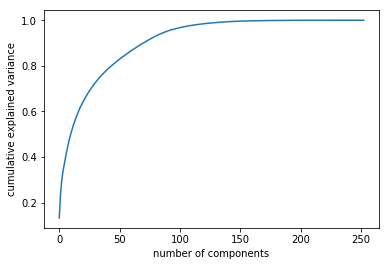

In [89]:
#set scalar
scaler = StandardScaler()
#fit scalar to train set
scaler.fit(X_train)
#transform train set
X_train_pc = scaler.transform(X_train)

#fit pca to scaled train set
pca = PCA().fit(X_train_pc)
#plot explained variance ratio curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#label x title
plt.xlabel('number of components')
#label y title
plt.ylabel('cumulative explained variance');

We see that 75% of our variance is explained by about 40 variables and 100% of our variance is explained by 100 features. Therefore in our pipeline, we will test for a range of 40 to 100 components.

The classifiers I chose to use are XGBoost, Logistic Regression and Random Forest. 

Logistic regression leads to simple understanding of our explanatory features and if speed is a factor, Logistic regression is the fastest. Random Forest may be a better choice for unbalanced data as it builds each tree independently and combines results at the end of the process through averaging. XGBoost is an additive model that combines results as it trains. Instead of training independently like Random Forest, it trains models in succession and corrects the errors made by the previous models. However, XGBoost is the hardest to tune.

Below, we have a dictionary of parameters to test for each classifier, and due to time constraints, I could not test for more in our gridsearch.

In [78]:
#set random state to replicate results
random_state = 42
#set a list of classifiers to test
classifiers = [XGBClassifier(random_state = random_state),
               LogisticRegression(random_state=random_state),
               RandomForestClassifier(random_state=random_state)]
#set our parameters for each classifier
params = [
        {'clf__n_estimators': [20,50,100],
     'clf__max_depth':[3,4,5,6],
     'pca__n_components':list(range(40,101))}, ## XGBoost
    
    {'clf__C':[0.001, .01, .10, 0.50, 0.75, 1.0, 10, 100],
     'pca__n_components': list(range(40,101))}, ## LogisticRegression
    
    {'clf__n_estimators': [20,50,100],
     'clf__criterion': ['entropy', 'gini'],
     'clf__max_depth':[None,3,4,5,6],
     'pca__n_components':list(range(60,101))} ## RandomForest
]

#create empty lists to keep best pipelines and best clfs
pipelines1 = []
best_clfs1 = []
#for loop iterating through each combination of classifier and its parameters
for clf,param in zip(classifiers,params):
    #set pipeline with list of standard scalar, pca and classifier
    pipe = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', clf)])
    #conduct gridsearch over parameter variable with 3-fold cross-validation running on all backend workers
    gs = GridSearchCV(estimator=pipe,
                  param_grid=param,
                  scoring='accuracy',
                  cv=3,
                  verbose=5,
                  n_jobs=-1)
    #fit model
    gs.fit(X_train, y_train)
    #append best estimator
    best_clfs1.append(gs.best_estimator_)
    #append pipeline
    pipelines1.append(pipe)
    #print clf and its name
    print(clf.__class__.__name__)
    #print params of best model
    print('Best params:', gs.best_params_)
    #print accuracy score of train set
    print('Train Accuracy:',gs.best_estimator_.score(X_train, y_train))
    #print accuracy score of test set
    print('Test Accuracy:',gs.best_estimator_.score(X_test, y_test))
    print('')

Fitting 3 folds for each of 732 candidates, totalling 2196 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 2196 out of 2196 | elapsed: 39.0min finished


XGBClassifier
Best params: {'clf__max_depth': 6, 'clf__n_estimators': 50, 'pca__n_components': 74}
Train Accuracy: 0.8914401867048106
Test Accuracy: 0.7294117647058823

Fitting 3 folds for each of 488 candidates, totalling 1464 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1464 out of 1464 | elapsed:  3.5min finished


LogisticRegression
Best params: {'clf__C': 100, 'pca__n_components': 98}
Train Accuracy: 0.7856658887299556
Test Accuracy: 0.6705882352941176

Fitting 3 folds for each of 1230 candidates, totalling 3690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 3690 out of 3690 | el

RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 100, 'pca__n_components': 75}
Train Accuracy: 1.0
Test Accuracy: 0.6823529411764706



The best classifier was the XGBoost with 74 components, max_depth = 6 and 50 estimators or trees. We will test again below, just for XGBoost classifier, but with a range of components 70 to 100, and a higher max_depth range.

In [81]:
#set our parameters
params = {'clf__n_estimators': [50],
     'clf__max_depth':[6,7,8],
     'pca__n_components':list(range(70,101))}
#set pipeline with list of standard scalar, pca and classifier
pipe = Pipeline([('scl', StandardScaler()),
                 ('pca', PCA()),
                 ('clf', XGBClassifier(random_state = 42))])
#conduct gridsearch over parameter variable with 3-fold cross-validation running on all backend workers
gs = GridSearchCV(estimator=pipe,
              param_grid=params,
              scoring='accuracy',
              cv=3,
              verbose=5,
              n_jobs=-1)
#fit model
gs.fit(X_train, y_train)
#print clf and its name
print(clf.__class__.__name__)
#print parameters of best model
print('Best params:', gs.best_params_)
#print accuracy score of train set
print('Train Accuracy:',gs.best_estimator_.score(X_train, y_train))
#print accuracy score of test set
print('Test Accuracy:',gs.best_estimator_.score(X_test, y_test))
print('')

Fitting 3 folds for each of 93 candidates, totalling 279 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 279 out of 279 | elapsed:  8.8min finished


RandomForestClassifier
Best params: {'clf__max_depth': 8, 'clf__n_estimators': 50, 'pca__n_components': 75}
Train Accuracy: 0.9701121734547918
Test Accuracy: 0.6941176470588235



We find that max_depth = 8 and 75 components is the best parameters for our XGBoost, but our test accuracy was lower whereas our train accuracy was higher, therefore, I will use the parameters from our pipeline above for XGBoost instead.

In [96]:
#set scalar
scaler = StandardScaler()
#fit scalar
scaler.fit(X_train)
#transform train and test set
X_trainnew = scaler.transform(X_train)
X_testnew = scaler.transform(X_test)

#fit and transform PCA with 74 components
pca = PCA(n_components=74)
pca.fit(X_trainnew)
X_train_pc = pca.transform(X_trainnew)
X_test_pc = pca.transform(X_testnew)

#check how long it takes to fit
import time
start = time.time()
#fit model wwith selected params
pca_clf = XGBClassifier(random_state = 42, max_depth = 6, n_estimators = 50).fit(X_train_pc,y_train)
print('Took', np.round(time.time()-start,2), 'seconds.')

#serialize model
filename = 'finalized_model.sav'
pickle.dump(pca_clf, open(filename, 'wb'))

#save predictions
trainpred = pca_clf.predict(X_train_pc)
predictions = pca_clf.predict(X_test_pc)

#print accuracy scores
print('Base Train Accuracy: ', accuracy_score(y_train, trainpred))
print('Base Test Accuracy: ', accuracy_score(y_test, predictions))

Took 5.73 seconds.
Base Train Accuracy:  0.897086501543326
Base Test Accuracy:  0.7529411764705882


After standardizing our data, conducting our PCA on our variables and fitting our model, our test accuracy reached its highest at 75.3%.

In [51]:
#serialize X_test_pc
with open('X_test_pc.pkl', 'wb') as f:
    pickle.dump(X_test_pc, f)

In [104]:
#serialize predictions
with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

<a id='r'></a>

[Back to Top of Notebook](#toc)
## Results

For our results, we will look at our classification report and accuracy metrics for our model above as well as take our model results from the seperate years data we have from our additionalinfo.ipynb file in our folder to see how well our classifier did in predicting with a training set of only that years' regular season.

In [43]:
#de-serialize model
pca_clf = pickle.load(open('finalized_model.sav', 'rb'))

In [19]:
#de-serialize predictions
with open('predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

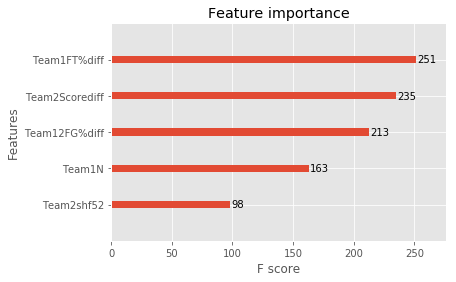

In [56]:
#get features names for model
pca_clf.get_booster().feature_names = list(X_test.columns)
#plot feature importance using F-score as metric
plot_importance(pca_clf, max_num_features = 5, importance_type = "weight")
plt.show()

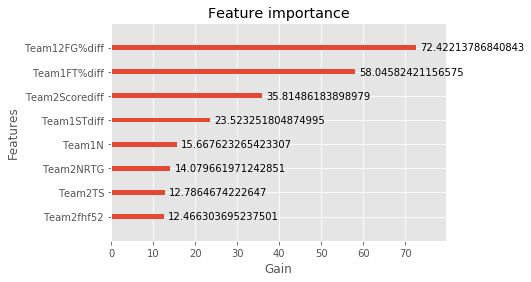

In [63]:
#plot feature importance using gain as metric
plot_importance(pca_clf, max_num_features = 8, importance_type = "gain", xlabel = 'Gain')
plt.show()

Using both F-score and gain as our metric in testing for feature importance for this model, we get different results. Before we understand which to choose, let us first go over what they both represent.

F-score relates to the frequency/over weight of our features, which is the percentage of the relative number of times a feature is present in the trees of the model. Gain, however, is the relative contribution of the feature taken by all of our feature’s contribution for each tree in the model. Gain shows the overall improvement in accuracy brought by a feature to the branches it is on.

Therefore, I would say Gain will be the most relevant metric to interpret the importance of my features.

We can see, the 8 most important features (in order) for predicting lower ID team winning are:

-- The average 2-point field goal percentage difference for lower ID team  
-- The average free throw percentage difference for lower ID team
-- The average score difference for higher ID team
-- The average steal difference for lower ID team
-- If the location is neutral for lower ID team
-- The average net rating of higher ID team
-- The average true shooting of higher ID team
-- The average 2 point field goal percentage of first 5 minutes of the first half for the higher ID team

It is obvious that the lower ID team's features were the most important but as you go down, the higher ID team's features influenced our accuracy more. It is interesting to note that our most important features value shooting in various ways, whether different areas of the floor or different time of the game. We have one feature relating to defense with steals and one feature referring to location of game, inferring that it is easier to predict if lower team ID will win the game whether the location is in a neutral site.

Confusion Matrix: 


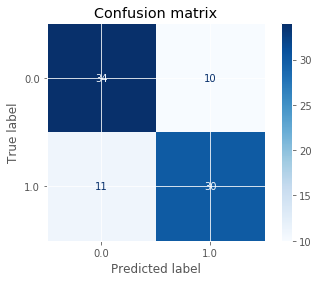



Accuracy Score: 
0.7529411764705882


Report: 
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76        44
         1.0       0.75      0.73      0.74        41

    accuracy                           0.75        85
   macro avg       0.75      0.75      0.75        85
weighted avg       0.75      0.75      0.75        85



AUC: 
0.7522172949002217
TPR: 
0.7317073170731707
TNR: 
0.7727272727272727


In [54]:
#plot confusion matrix
print('Confusion Matrix: ')
plot_confusion_matrix(pca_clf, X_test_pc, y_test, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.show()
print()
print()
#print test accuracy score
print('Accuracy Score: ')
print(accuracy_score(y_test, predictions))
print()
print()
#print classification report
print('Report: ')
print(classification_report(y_test, predictions))
print()
print()
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
#print area under roc curve
print('AUC: ')
print(np.trapz(tpr,fpr))
#print true positive rate
print('TPR: ')
print(tpr[1])
#print true negative rate
print('TNR: ')
print(1 - fpr[1])

When training over combined regular season data, we get an accuracy score of 75.3%, having a true positive rate of 73.2% and true negative rate of 77.3%. Therefore, we were more successful in predicting that the team with the higher team ID wins. After looking at our data, I actually know that 65.2% of our upsets have a higher team ID, which means we may have done an adequate job at predicting upsets. Our area under the ROC curve is 75.2%, which considering the wild nature of sports events, is a consistent job. 

In [32]:
check = y_test - predictions
correct = []
incorrect = []

#for loop iterating through list, appending index to corresponding list if prediction was correct or not
for idx, x in enumerate(check):
    if x == 0:
        correct.append(idx)
    elif x != 0:
        incorrect.append(idx)
#display length of correct and incorrect lists
display(len(correct))
display(len(incorrect))

64

21

We have predicted 64 out of 85 matchups correctly.

In [81]:
print('Correct')
count = 0
#create dictionaries for each season's results
results2017 = {'Win': [], 'Loss': [], 'Correct': []}
results2018 = {'Win': [], 'Loss': [], 'Correct': []}
results2019 = {'Win': [], 'Loss': [], 'Correct': []}

#for loop iterating through correct list
for x in correct:
    #restricting values in team1 dataframe copy to leave one possible team index
    team1 = df20[df20['Scorediff2017'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2017'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2017'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2017'] == X_test['Team12FG%diff'].iloc[x]]
    idx12017 = team1.index
    
    team1 = df20[df20['Scorediff2018'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2018'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2018'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2018'] == X_test['Team12FG%diff'].iloc[x]]
    idx12018 = team1.index
    
    team1 = df20[df20['Scorediff2019'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2019'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2019'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2019'] == X_test['Team12FG%diff'].iloc[x]]
    idx12019 = team1.index

    #restricting values in team2 dataframe copy to leave one possible team index
    team2 = df20[df20['Scorediff2017'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2017'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2017'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2017'] == X_test['Team22FG%diff'].iloc[x]]
    idx22017 = team2.index
    
    team2 = df20[df20['Scorediff2018'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2018'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2018'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2018'] == X_test['Team22FG%diff'].iloc[x]]
    idx22018 = team2.index
    
    team2 = df20[df20['Scorediff2019'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2019'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2019'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2019'] == X_test['Team22FG%diff'].iloc[x]]
    idx22019 = team2.index
    
    #check if length of index array for each season for both winner and loser have values
    if (len(idx12017) != 0) and (len(idx22017) != 0):
        idx1 = idx12017[0]
        idx2 = idx22017[0]
        print('2017 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2017['Win'].append(df20.TeamID.iloc[idx1])
            results2017['Loss'].append(df20.TeamID.iloc[idx2])
            results2017['Correct'].append(1)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2017['Win'].append(df20.TeamID.iloc[idx2])
            results2017['Loss'].append(df20.TeamID.iloc[idx1])
            results2017['Correct'].append(1)
        print()
        print()
        count += 1                     
    elif (len(idx12018) != 0) and (len(idx22018) != 0):
        idx1 = idx12018[0]
        idx2 = idx22018[0]
        print('2018 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2018['Win'].append(df20.TeamID.iloc[idx1])
            results2018['Loss'].append(df20.TeamID.iloc[idx2])
            results2018['Correct'].append(1)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2018['Win'].append(df20.TeamID.iloc[idx2])
            results2018['Loss'].append(df20.TeamID.iloc[idx1])
            results2018['Correct'].append(1)
        print()
        print()
        count += 1
    elif (len(idx12019) != 0) and (len(idx22019) != 0):
        idx1 = idx12019[0]
        idx2 = idx22019[0]
        print('2019 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2019['Win'].append(df20.TeamID.iloc[idx1])
            results2019['Loss'].append(df20.TeamID.iloc[idx2])
            results2019['Correct'].append(1)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2019['Win'].append(df20.TeamID.iloc[idx2])
            results2019['Loss'].append(df20.TeamID.iloc[idx1])
            results2019['Correct'].append(1)
        print()
        print()
        count += 1

print('Incorrect')
#for loop iterating through incorrect list
for x in incorrect:
    #restricting values in team1 dataframe copy to leave one possible team index
    team1 = df20[df20['Scorediff2017'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2017'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2017'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2017'] == X_test['Team12FG%diff'].iloc[x]]
    idx12017 = team1.index
    
    team1 = df20[df20['Scorediff2018'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2018'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2018'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2018'] == X_test['Team12FG%diff'].iloc[x]]
    idx12018 = team1.index
    
    team1 = df20[df20['Scorediff2019'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2019'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2019'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2019'] == X_test['Team12FG%diff'].iloc[x]]
    idx12019 = team1.index

    #restricting values in team2 dataframe copy to leave one possible team index
    team2 = df20[df20['Scorediff2017'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2017'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2017'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2017'] == X_test['Team22FG%diff'].iloc[x]]
    idx22017 = team2.index
    
    team2 = df20[df20['Scorediff2018'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2018'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2018'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2018'] == X_test['Team22FG%diff'].iloc[x]]
    idx22018 = team2.index
    
    team2 = df20[df20['Scorediff2019'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2019'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2019'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2019'] == X_test['Team22FG%diff'].iloc[x]]
    idx22019 = team2.index
    
    #check if length of index array for each season for both winner and loser have values
    if (len(idx12017) != 0) and (len(idx22017) != 0):
        idx1 = idx12017[0]
        idx2 = idx22017[0]
        print('2017 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2017['Win'].append(df20.TeamID.iloc[idx1])
            results2017['Loss'].append(df20.TeamID.iloc[idx2])
            results2017['Correct'].append(0)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2017['Win'].append(df20.TeamID.iloc[idx2])
            results2017['Loss'].append(df20.TeamID.iloc[idx1])
            results2017['Correct'].append(0)
        print()
        print()
        count += 1
    elif (len(idx12018) != 0) and (len(idx22018) != 0):
        idx1 = idx12018[0]
        idx2 = idx22018[0]
        print('2018 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2018['Win'].append(df20.TeamID.iloc[idx1])
            results2018['Loss'].append(df20.TeamID.iloc[idx2])
            results2018['Correct'].append(0)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2018['Win'].append(df20.TeamID.iloc[idx2])
            results2018['Loss'].append(df20.TeamID.iloc[idx1])
            results2018['Correct'].append(0)
        print()
        print()
        count += 1
    elif (len(idx12019) != 0) and (len(idx22019) != 0):
        idx1 = idx12019[0]
        idx2 = idx22019[0]
        print('2019 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2019['Win'].append(df20.TeamID.iloc[idx1])
            results2019['Loss'].append(df20.TeamID.iloc[idx2])
            results2019['Correct'].append(0)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2019['Win'].append(df20.TeamID.iloc[idx2])
            results2019['Loss'].append(df20.TeamID.iloc[idx1])
            results2019['Correct'].append(0)
        print()
        print()
        count += 1
print(count)

Correct
2017 Season
Arizona: 1112
North Dakota: 1315
Arizona won


2017 Season
Butler: 1139
Winthrop: 1457
Butler won


2017 Season
ETSU: 1190
Florida: 1196
Florida won


2017 Season
FL Gulf Coast: 1195
Florida St: 1199
Florida St won


2017 Season
Gonzaga: 1211
S Dakota St: 1355
Gonzaga won


2017 Season
Iowa St: 1235
Nevada: 1305
Iowa St won


2017 Season
Minnesota: 1278
MTSU: 1292
MTSU won


2017 Season
Northwestern: 1321
Vanderbilt: 1435
Northwestern won


2017 Season
Notre Dame: 1323
Princeton: 1343
Notre Dame won


2017 Season
St Mary's CA: 1388
VCU: 1433
St Mary's CA won


2017 Season
Mt St Mary's: 1291
Villanova: 1437
Villanova won


2017 Season
UNC Wilmington: 1423
Virginia: 1438
Virginia won


2017 Season
Virginia Tech: 1439
Wisconsin: 1458
Wisconsin won


2017 Season
Arkansas: 1116
Seton Hall: 1371
Arkansas won


2017 Season
Cincinnati: 1153
Kansas St: 1243
Cincinnati won


2017 Season
Duke: 1181
Troy: 1407
Duke won


2017 Season
Kansas: 1242
UC Davis: 1413
Kansas won


2017

Above we have printed the specific game details (TeamID, Teams, Winner) in which were predicted correctly and incorrectly, so that we may watch film and compare if the model was able to see something the eye wouldn't be able to.

In [82]:
#create dataframe from results dictionary
results2017 = pd.DataFrame.from_dict(results2017)
results2018 = pd.DataFrame.from_dict(results2018)
results2019 = pd.DataFrame.from_dict(results2019)

In [84]:
#for loops iterating through results dataframes
#creating winning and losing team proxy dataframes for specified year
#placing winning seed value, losing seed value, seed difference and indicating if it were an upset or not

for idx, x in enumerate(results2017.Win):
    teamw = df21[df21.TeamID == x]
    teamw = teamw[teamw.Season == 2017]
    teaml = df21[df21.TeamID == results2017.Loss.iloc[idx]]
    teaml = teaml[teaml.Season == 2017]
    results2017.loc[idx, 'WSeed'] = int(teamw.Seed.iloc[0][1:3])
    results2017.loc[idx, 'LSeed'] = int(teaml.Seed.iloc[0][1:3])
    results2017.loc[idx, 'Seeddiff'] = results2017.WSeed.iloc[idx] - results2017.LSeed.iloc[idx]
    if results2017.Seeddiff.iloc[idx] < 0:
        results2017.loc[idx, 'Upset'] = 0
    elif results2017.Seeddiff.iloc[idx] > 0:
        results2017.loc[idx, 'Upset'] = 1

for idx, x in enumerate(results2018.Win):
    teamw = df21[df21.TeamID == x]
    teamw = teamw[teamw.Season == 2018]
    teaml = df21[df21.TeamID == results2018.Loss.iloc[idx]]
    teaml = teaml[teaml.Season == 2018]
    results2018.loc[idx, 'WSeed'] = int(teamw.Seed.iloc[0][1:3])
    results2018.loc[idx, 'LSeed'] = int(teaml.Seed.iloc[0][1:3])
    results2018.loc[idx, 'Seeddiff'] = results2018.WSeed.iloc[idx] - results2018.LSeed.iloc[idx]
    if results2018.Seeddiff.iloc[idx] < 0:
        results2018.loc[idx, 'Upset'] = 0
    elif results2018.Seeddiff.iloc[idx] > 0:
        results2018.loc[idx, 'Upset'] = 1
        
for idx, x in enumerate(results2019.Win):
    teamw = df21[df21.TeamID == x]
    teamw = teamw[teamw.Season == 2019]
    teaml = df21[df21.TeamID == results2019.Loss.iloc[idx]]
    teaml = teaml[teaml.Season == 2019]
    results2019.loc[idx, 'WSeed'] = int(teamw.Seed.iloc[0][1:3])
    results2019.loc[idx, 'LSeed'] = int(teaml.Seed.iloc[0][1:3])
    results2019.loc[idx, 'Seeddiff'] = results2019.WSeed.iloc[idx] - results2019.LSeed.iloc[idx]
    if results2019.Seeddiff.iloc[idx] < 0:
        results2019.loc[idx, 'Upset'] = 0
    elif results2019.Seeddiff.iloc[idx] > 0:
        results2019.loc[idx, 'Upset'] = 1

In [92]:
print(2017)
display(results2017.sample(5))
print(2018)
display(results2018.sample(5))
print(2019)
results2019.sample(5)

2017


,Win,Loss,Correct,WSeed,LSeed,Seeddiff,Upset
26,1348,1166,0,11.0,6.0,5.0,1.0
5,1235,1305,1,5.0,12.0,-7.0,0.0
28,1425,1374,0,11.0,6.0,5.0,1.0
10,1437,1291,1,1.0,16.0,-15.0,0.0
15,1181,1407,1,2.0,15.0,-13.0,0.0


2018


,Win,Loss,Correct,WSeed,LSeed,Seeddiff,Upset
3,1242,1335,1,1.0,16.0,-15.0,0.0
23,1403,1372,0,3.0,14.0,-11.0,0.0
14,1199,1281,1,9.0,8.0,1.0,1.0
21,1196,1382,0,6.0,11.0,-5.0,0.0
11,1120,1158,1,4.0,13.0,-9.0,0.0


2019


,Win,Loss,Correct,WSeed,LSeed,Seeddiff,Upset
8,1459,1371,1,7.0,10.0,-3.0,0.0
17,1439,1387,1,4.0,13.0,-9.0,0.0
9,1138,1113,1,6.0,11.0,-5.0,0.0
5,1276,1285,1,2.0,15.0,-13.0,0.0
21,1199,1436,0,4.0,13.0,-9.0,0.0


In [86]:
#grouping sum of upsets by correct column
resultsupsettable2017 = results2017.groupby(['Correct'])['Upset'].agg({x:['sum']}).reset_index()
#rename columns of groupby dataframe
resultsupsettable2017.columns = ['Correct', 'Upset']
print(2017)
#display dataframe
display(resultsupsettable2017)
print()
#grouping sum of upsets by correct column
resultsupsettable2018 = results2018.groupby(['Correct'])['Upset'].agg({x:['sum']}).reset_index()
#rename columns of groupby dataframe
resultsupsettable2018.columns = ['Correct', 'Upset']
print(2018)
#display dataframe
display(resultsupsettable2018)
print()
#grouping sum of upsets by correct column
resultsupsettable2019 = results2019.groupby(['Correct'])['Upset'].agg({x:['sum']}).reset_index()
#rename columns of groupby dataframe
resultsupsettable2019.columns = ['Correct', 'Upset']
print(2019)
#display dataframe
display(resultsupsettable2019)
print()

print()
print(2017)
#print value counts of correct column
print(results2017.Correct.value_counts())
print()

print()
print(2018)
#print value counts of correct column
print(results2018.Correct.value_counts())
print()

print()
print(2019)
#print value counts of correct column
print(results2019.Correct.value_counts())
print()

2017


,Correct,Upset
0,0,2.0
1,1,3.0



2018


,Correct,Upset
0,0,3.0
1,1,4.0



2019


,Correct,Upset
0,0,6.0
1,1,5.0




2017
1    25
0     4
Name: Correct, dtype: int64


2018
1    20
0     8
Name: Correct, dtype: int64


2019
1    19
0     9
Name: Correct, dtype: int64



As for predicting upsets, for 2017 and 2018, we have predicted over 50%. In 2017, we predicted 60% of our upsets correctly and 86.2% of our overall matchups. In 2018, we predicted 57.1% of our upsets correctly and 71.4% of our overall matchups. In 2019 however, we only predicted 45.5% of our upsets correctly and 67.9% of our overall matchups. As said earlier, individual players with greater skill attended smaller schools, and as our model doesn't include the impact of individual player talent, it is hard to weigh in the influence of a player's talent into the outcome of a game. The tournament is a time in which the best players shine and so it is possible that there are many factors I am not accounting for.

Regardless, let us look at our real predictions, when we train over each season independently to predict.

### Seperate Years

In [13]:
#de-serialize seperate year predictions
with open('trainpred2017.pkl', 'rb') as a:
    trainpred2017 = pickle.load(a)

with open('predictions2017.pkl', 'rb') as b:
    predictions2017 = pickle.load(b)
    
with open('trainpred2018.pkl', 'rb') as c:
    trainpred2018 = pickle.load(c)
    
with open('predictions2018.pkl', 'rb') as d:
    predictions2018 = pickle.load(d)
    
with open('trainpred2019.pkl', 'rb') as e:
    trainpred2019 = pickle.load(e)
    
with open('predictions2019.pkl', 'rb') as g:
    predictions2019 = pickle.load(g)

In [14]:
#concat arrays
seperateyears = np.concatenate((predictions2017, predictions2018, predictions2019), axis=None)

In [60]:
#plot confusion matrix
print('Confusion Matrix: ')
print(confusion_matrix(y_test, seperateyears))
print()
print()
#print test accuracy score
print('Accuracy Score: ')
print(accuracy_score(y_test, seperateyears))
print()
print()
#print classification report
print('Report: ')
print(classification_report(y_test, seperateyears))
print()
print()
fpr, tpr, threshold = metrics.roc_curve(y_test, seperateyears)
#print area under roc curve
print('AUC: ')
print(np.trapz(tpr,fpr))
#print true positive rate
print('TPR: ')
print(tpr[1])
#print true negative rate
print('TNR: ')
print(1 - fpr[1])

Confusion Matrix: 
[[35  9]
 [11 30]]


Accuracy Score: 
0.7647058823529411


Report: 
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78        44
         1.0       0.77      0.73      0.75        41

    accuracy                           0.76        85
   macro avg       0.77      0.76      0.76        85
weighted avg       0.76      0.76      0.76        85



AUC: 
0.7635809312638581
TPR: 
0.7317073170731707
TNR: 
0.7954545454545454


When training over each season independently, we get an accuracy score of 76.5% for all three years, having a true positive rate of 73.2% and true negative rate of 79.5%. Therefore, we were even more successful in predicting that the team with the higher team ID wins.

This means, we were more succesfull in predicting matchups when using statistics for that specific season's games.

Below, we can run the same code to find the predictions of upsets.

In [15]:
checksy = y_test - seperateyears
correctsy = []
incorrectsy = []

#for loop iterating through list, appending index to corresponding list if prediction was correct or not
for idx, x in enumerate(checksy):
    if x == 0:
        correctsy.append(idx)
    elif x != 0:
        incorrectsy.append(idx)
#display length of seperate years correct and incorrect lists
display(len(correctsy))
display(len(incorrectsy))

65

20

In [16]:
print('Correct')
count = 0
#create dictionaries for each season's results
results2017sy = {'Win': [], 'Loss': [], 'Correct': []}
results2018sy = {'Win': [], 'Loss': [], 'Correct': []}
results2019sy = {'Win': [], 'Loss': [], 'Correct': []}

#for loop iterating through correct list
for x in correctsy:
    #restricting values in team1 dataframe copy to leave one possible team index
    team1 = df20[df20['Scorediff2017'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2017'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2017'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2017'] == X_test['Team12FG%diff'].iloc[x]]
    idx12017 = team1.index
    
    team1 = df20[df20['Scorediff2018'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2018'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2018'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2018'] == X_test['Team12FG%diff'].iloc[x]]
    idx12018 = team1.index
    
    team1 = df20[df20['Scorediff2019'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2019'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2019'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2019'] == X_test['Team12FG%diff'].iloc[x]]
    idx12019 = team1.index

    #restricting values in team2 dataframe copy to leave one possible team index
    team2 = df20[df20['Scorediff2017'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2017'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2017'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2017'] == X_test['Team22FG%diff'].iloc[x]]
    idx22017 = team2.index
    
    team2 = df20[df20['Scorediff2018'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2018'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2018'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2018'] == X_test['Team22FG%diff'].iloc[x]]
    idx22018 = team2.index
    
    team2 = df20[df20['Scorediff2019'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2019'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2019'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2019'] == X_test['Team22FG%diff'].iloc[x]]
    idx22019 = team2.index
    
    #check if length of index array for each season for both winner and loser have values
    if (len(idx12017) != 0) and (len(idx22017) != 0):
        idx1 = idx12017[0]
        idx2 = idx22017[0]
        print('2017 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2017sy['Win'].append(df20.TeamID.iloc[idx1])
            results2017sy['Loss'].append(df20.TeamID.iloc[idx2])
            results2017sy['Correct'].append(1)
            #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2017sy['Win'].append(df20.TeamID.iloc[idx2])
            results2017sy['Loss'].append(df20.TeamID.iloc[idx1])
            results2017sy['Correct'].append(1)
        print()
        print()
        count += 1                     
    elif (len(idx12018) != 0) and (len(idx22018) != 0):
        idx1 = idx12018[0]
        idx2 = idx22018[0]
        print('2018 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2018sy['Win'].append(df20.TeamID.iloc[idx1])
            results2018sy['Loss'].append(df20.TeamID.iloc[idx2])
            results2018sy['Correct'].append(1)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2018sy['Win'].append(df20.TeamID.iloc[idx2])
            results2018sy['Loss'].append(df20.TeamID.iloc[idx1])
            results2018sy['Correct'].append(1)
        print()
        print()
        count += 1
    elif (len(idx12019) != 0) and (len(idx22019) != 0):
        idx1 = idx12019[0]
        idx2 = idx22019[0]
        print('2019 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2019sy['Win'].append(df20.TeamID.iloc[idx1])
            results2019sy['Loss'].append(df20.TeamID.iloc[idx2])
            results2019sy['Correct'].append(1)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2019sy['Win'].append(df20.TeamID.iloc[idx2])
            results2019sy['Loss'].append(df20.TeamID.iloc[idx1])
            results2019sy['Correct'].append(1)
        print()
        print()
        count += 1

print('Incorrect')
#for loop iterating through incorrect list
for x in incorrectsy:
    #restricting values in team1 dataframe copy to leave one possible team index
    team1 = df20[df20['Scorediff2017'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2017'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2017'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2017'] == X_test['Team12FG%diff'].iloc[x]]
    idx12017 = team1.index
    
    team1 = df20[df20['Scorediff2018'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2018'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2018'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2018'] == X_test['Team12FG%diff'].iloc[x]]
    idx12018 = team1.index
    
    team1 = df20[df20['Scorediff2019'] == X_test['Team1Scorediff'].iloc[x]]
    team1 = team1[team1['2FGMdiff2019'] == X_test['Team12FGMdiff'].iloc[x]]
    team1 = team1[team1['3FG%diff2019'] == X_test['Team13FG%diff'].iloc[x]]
    team1 = team1[team1['2FG%diff2019'] == X_test['Team12FG%diff'].iloc[x]]
    idx12019 = team1.index

    #restricting values in team2 dataframe copy to leave one possible team index
    team2 = df20[df20['Scorediff2017'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2017'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2017'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2017'] == X_test['Team22FG%diff'].iloc[x]]
    idx22017 = team2.index
    
    team2 = df20[df20['Scorediff2018'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2018'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2018'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2018'] == X_test['Team22FG%diff'].iloc[x]]
    idx22018 = team2.index
    
    team2 = df20[df20['Scorediff2019'] == X_test['Team2Scorediff'].iloc[x]]
    team2 = team2[team2['2FGMdiff2019'] == X_test['Team22FGMdiff'].iloc[x]]
    team2 = team2[team2['3FG%diff2019'] == X_test['Team23FG%diff'].iloc[x]]
    team2 = team2[team2['2FG%diff2019'] == X_test['Team22FG%diff'].iloc[x]]
    idx22019 = team2.index
    
    #check if length of index array for each season for both winner and loser have values
    if (len(idx12017) != 0) and (len(idx22017) != 0):
        idx1 = idx12017[0]
        idx2 = idx22017[0]
        print('2017 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2017sy['Win'].append(df20.TeamID.iloc[idx1])
            results2017sy['Loss'].append(df20.TeamID.iloc[idx2])
            results2017sy['Correct'].append(0)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2017sy['Win'].append(df20.TeamID.iloc[idx2])
            results2017sy['Loss'].append(df20.TeamID.iloc[idx1])
            results2017sy['Correct'].append(0)
        print()
        print()
        count += 1
    elif (len(idx12018) != 0) and (len(idx22018) != 0):
        idx1 = idx12018[0]
        idx2 = idx22018[0]
        print('2018 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2018sy['Win'].append(df20.TeamID.iloc[idx1])
            results2018sy['Loss'].append(df20.TeamID.iloc[idx2])
            results2018sy['Correct'].append(0)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2018sy['Win'].append(df20.TeamID.iloc[idx2])
            results2018sy['Loss'].append(df20.TeamID.iloc[idx1])
            results2018sy['Correct'].append(0)
        print()
        print()
        count += 1
    elif (len(idx12019) != 0) and (len(idx22019) != 0):
        idx1 = idx12019[0]
        idx2 = idx22019[0]
        print('2019 Season')
        print(str(df20.TeamName.iloc[idx1]) + ': ' + str(df20.TeamID.iloc[idx1]))
        print(str(df20.TeamName.iloc[idx2]) + ': ' + str(df20.TeamID.iloc[idx2]))
        #print winner and append results to corresponding list in results dictionary
        if y_test[x + 13283] == 1:
            print(str(df20.TeamName.iloc[idx1]) + ' won')
            results2019sy['Win'].append(df20.TeamID.iloc[idx1])
            results2019sy['Loss'].append(df20.TeamID.iloc[idx2])
            results2019sy['Correct'].append(0)
        #print winner and append results to corresponding list in results dictionary
        elif y_test[x + 13283] == 0:
            print(str(df20.TeamName.iloc[idx2]) + ' won')
            results2019sy['Win'].append(df20.TeamID.iloc[idx2])
            results2019sy['Loss'].append(df20.TeamID.iloc[idx1])
            results2019sy['Correct'].append(0)
        print()
        print()
        count += 1
print(count)

Correct
2017 Season
Arizona: 1112
North Dakota: 1315
Arizona won


2017 Season
Butler: 1139
Winthrop: 1457
Butler won


2017 Season
ETSU: 1190
Florida: 1196
Florida won


2017 Season
FL Gulf Coast: 1195
Florida St: 1199
Florida St won


2017 Season
Gonzaga: 1211
S Dakota St: 1355
Gonzaga won


2017 Season
Iowa St: 1235
Nevada: 1305
Iowa St won


2017 Season
Minnesota: 1278
MTSU: 1292
MTSU won


2017 Season
Northwestern: 1321
Vanderbilt: 1435
Northwestern won


2017 Season
Notre Dame: 1323
Princeton: 1343
Notre Dame won


2017 Season
St Mary's CA: 1388
VCU: 1433
St Mary's CA won


2017 Season
Mt St Mary's: 1291
Villanova: 1437
Villanova won


2017 Season
UNC Wilmington: 1423
Virginia: 1438
Virginia won


2017 Season
Virginia Tech: 1439
Wisconsin: 1458
Wisconsin won


2017 Season
Arkansas: 1116
Seton Hall: 1371
Arkansas won


2017 Season
Cincinnati: 1153
Kansas St: 1243
Cincinnati won


2017 Season
Duke: 1181
Troy: 1407
Duke won


2017 Season
Kansas: 1242
UC Davis: 1413
Kansas won


2017

In [17]:
#create dataframe from results dictionary for seperate years
results2017sy = pd.DataFrame.from_dict(results2017sy)
results2018sy = pd.DataFrame.from_dict(results2018sy)
results2019sy = pd.DataFrame.from_dict(results2019sy)

In [18]:
#for loops iterating through results dataframes
#creating winning and losing team proxy dataframes for specified year
#placing winning seed value, losing seed value, seed difference and indicating if it were an upset or not

for idx, x in enumerate(results2017sy.Win):
    teamw = df21[df21.TeamID == x]
    teamw = teamw[teamw.Season == 2017]
    teaml = df21[df21.TeamID == results2017sy.Loss.iloc[idx]]
    teaml = teaml[teaml.Season == 2017]
    results2017sy.loc[idx, 'WSeed'] = int(teamw.Seed.iloc[0][1:3])
    results2017sy.loc[idx, 'LSeed'] = int(teaml.Seed.iloc[0][1:3])
    results2017sy.loc[idx, 'Seeddiff'] = results2017sy.WSeed.iloc[idx] - results2017sy.LSeed.iloc[idx]
    if results2017sy.Seeddiff.iloc[idx] < 0:
        results2017sy.loc[idx, 'Upset'] = 0
    elif results2017sy.Seeddiff.iloc[idx] > 0:
        results2017sy.loc[idx, 'Upset'] = 1

for idx, x in enumerate(results2018sy.Win):
    teamw = df21[df21.TeamID == x]
    teamw = teamw[teamw.Season == 2018]
    teaml = df21[df21.TeamID == results2018sy.Loss.iloc[idx]]
    teaml = teaml[teaml.Season == 2018]
    results2018sy.loc[idx, 'WSeed'] = int(teamw.Seed.iloc[0][1:3])
    results2018sy.loc[idx, 'LSeed'] = int(teaml.Seed.iloc[0][1:3])
    results2018sy.loc[idx, 'Seeddiff'] = results2018sy.WSeed.iloc[idx] - results2018sy.LSeed.iloc[idx]
    if results2018sy.Seeddiff.iloc[idx] < 0:
        results2018sy.loc[idx, 'Upset'] = 0
    elif results2018sy.Seeddiff.iloc[idx] > 0:
        results2018sy.loc[idx, 'Upset'] = 1
        
for idx, x in enumerate(results2019sy.Win):
    teamw = df21[df21.TeamID == x]
    teamw = teamw[teamw.Season == 2019]
    teaml = df21[df21.TeamID == results2019sy.Loss.iloc[idx]]
    teaml = teaml[teaml.Season == 2019]
    results2019sy.loc[idx, 'WSeed'] = int(teamw.Seed.iloc[0][1:3])
    results2019sy.loc[idx, 'LSeed'] = int(teaml.Seed.iloc[0][1:3])
    results2019sy.loc[idx, 'Seeddiff'] = results2019sy.WSeed.iloc[idx] - results2019sy.LSeed.iloc[idx]
    if results2019sy.Seeddiff.iloc[idx] < 0:
        results2019sy.loc[idx, 'Upset'] = 0
    elif results2019sy.Seeddiff.iloc[idx] > 0:
        results2019sy.loc[idx, 'Upset'] = 1

In [19]:
#grouping sum of upsets by correct column
resultsupsettable2017sy = results2017sy.groupby(['Correct'])['Upset'].agg({x:['sum']}).reset_index()
#rename columns of groupby dataframe
resultsupsettable2017sy.columns = ['Correct', 'Upset']
print(2017)
#display dataframe
display(resultsupsettable2017sy)
print()
#grouping sum of upsets by correct column
resultsupsettable2018sy = results2018sy.groupby(['Correct'])['Upset'].agg({x:['sum']}).reset_index()
#rename columns of groupby dataframe
resultsupsettable2018sy.columns = ['Correct', 'Upset']
print(2018)
#display dataframe
display(resultsupsettable2018sy)
print()
#grouping sum of upsets by correct column
resultsupsettable2019sy = results2019sy.groupby(['Correct'])['Upset'].agg({x:['sum']}).reset_index()
#rename columns of groupby dataframe
resultsupsettable2019sy.columns = ['Correct', 'Upset']
print(2019)
#display dataframe
display(resultsupsettable2019sy)
print()

print()
print(2017)
#print value counts of correct column
print(results2017sy.Correct.value_counts())
print()

print()
print(2018)
#print value counts of correct column
print(results2018sy.Correct.value_counts())
print()

print()
print(2019)
#print value counts of correct column
print(results2019sy.Correct.value_counts())
print()

2017


,Correct,Upset
0,0,2.0
1,1,3.0



2018


,Correct,Upset
0,0,4.0
1,1,3.0



2019


,Correct,Upset
0,0,5.0
1,1,6.0




2017
1    25
0     4
Name: Correct, dtype: int64


2018
1    20
0     8
Name: Correct, dtype: int64


2019
1    20
0     8
Name: Correct, dtype: int64



As for predicting upsets, for 2017 and 2019, we have predicted over 50%.

In 2017, we predicted 60% of our upsets correctly and 86.2% of our overall matchups. In 2018, we predicted 42.9% of our upsets correctly instead but still 71.4% of our overall matchups. In 2019 however, we have now predicted 54.5% of our upsets correctly and also 71.4% of our overall matchups.

Although in 2018 we did not predict upsets at the same accuracy as before, we still predicted the same accuracy for overall first round matchup while improving in 2019, the more sporadic year of upsets.

There are various factors that influence a basketball game, not only in the statistics but also external factors like elevation of performance and momentum heading into a game. How to value importance of those factors for each game is another issues as one variable may be more important than another depending on the opponent and day. It is important to note that we were successful in predicting just over 76% of first round matchups using solely regular season results. With more in depth understanding of feature engineering for this topic, feature importance and gathering of data outside of regular season, we may construct a more accurate model.

<a id='fw'></a>

[Back to Top of Notebook](#toc)
## Future Work

- Include individual player significance
- Include secondary tournament results
- Include past tournament results
- A better understanding of incorrectly predicted matches
- Find better parameters for classifiers
- Arrange target to show upset winning rather than lower Team ID
- Make functions more efficient